# Running Model

Calibrated params from calibration_us_gdp.ipynb

In [1]:
# Import packages
from abm_funs import *
from plot_funs import*
# from us_input import *
import numpy as np
from copy import deepcopy 
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress
import math as math
import importlib
from copy import deepcopy
import os
import seaborn as sns
import datetime
from collate_macro_vars import *
from statsmodels.tsa.filters import hp_filter, bk_filter, cf_filter
from quantecon import hamilton_filter
from statsmodels.tsa.seasonal import seasonal_decompose
import csv

rng = np.random.default_rng()
test_fun()

path = "~/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/"

import os
print(os.cpu_count()) 

save = False

NEW Function import successful
8


/var/folders/34/6r0xdq916zn1qsvypkxnsqkw0000gr/T/ipykernel_26320/4051325385.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset['OBS_VALUE'] = hp_filter.hpfilter(subset['OBS_VALUE'], lamb=1600)[0]


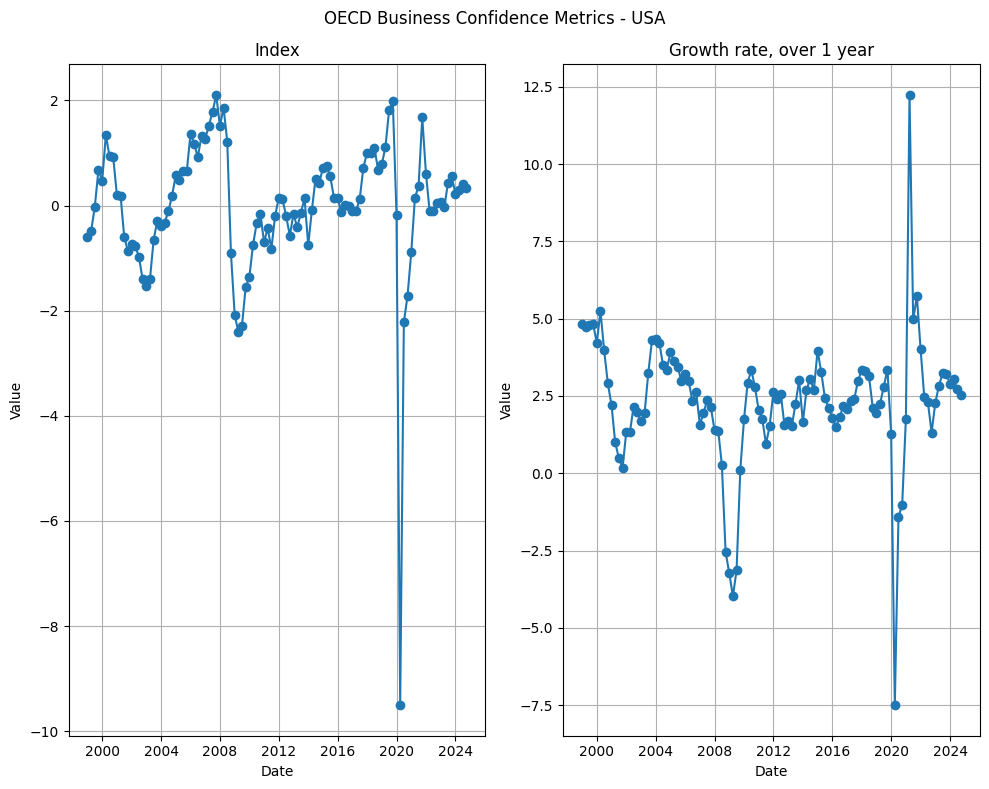

In [2]:
# Load and clean OECD business confidence data
# Source: https://www.oecd.org/en/data/indicators/business-confidence-index-bci.html
bus_conf = pd.read_csv(path + "data/macro_vars/OECD_bus_conf_usa.csv")
bus_conf = bus_conf.loc[:, bus_conf.nunique() > 1]  # fix: assign back
bus_conf['DATE'] = pd.PeriodIndex(bus_conf['TIME_PERIOD'], freq='Q').start_time
bus_conf = bus_conf.sort_values(by='DATE')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 8))

# Plot each transformation type
for i, index_type in enumerate(bus_conf['Transformation'].unique()):
    subset = bus_conf[bus_conf['Transformation'] == index_type]
    if index_type == "Index":
        subset['OBS_VALUE'] = hp_filter.hpfilter(subset['OBS_VALUE'], lamb=1600)[0]
    ax = axes[i]  # fix: access subplot properly
    ax.plot(subset['DATE'], subset['OBS_VALUE'], marker='o')
    ax.set_title(f'{index_type}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')
    ax.grid(True)

plt.suptitle('OECD Business Confidence Metrics - USA')
plt.tight_layout()
plt.show()

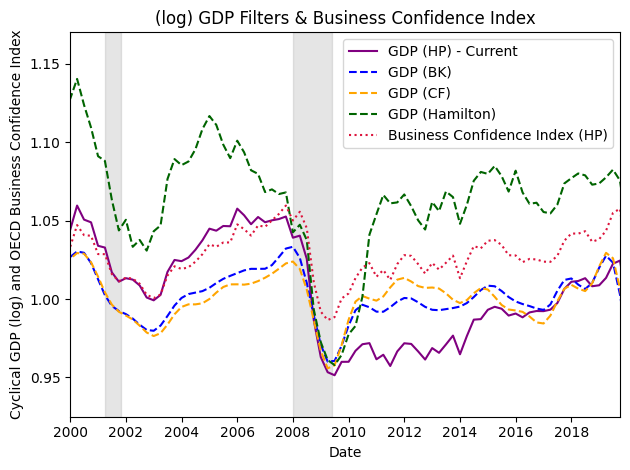

In [3]:
#realgdp = macro_observations[["DATE", "REALGDP"]].dropna(subset=["REALGDP"]).reset_index()
realgdp['log_REALGDP'] = np.log2(realgdp['REALGDP'])

# GDP Filter
cycle, trend = hp_filter.hpfilter(realgdp['log_REALGDP'], lamb=129600)
 
# Adding the trend and cycle to the original DataFrame
realgdp['log_Trend'] = trend+1
realgdp['log_Cycle'] = cycle+1
realgdp['Trend'] = np.exp(trend)
realgdp['Cycle'] = np.exp(cycle)

realgdp_no_covid = realgdp[realgdp['DATE'] < "2019-10-1"].copy()
realgdp['scaled_log_Cycle'] = (realgdp['log_Cycle'] - realgdp['log_Cycle'].min()) / (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min())
realgdp_no_covid['scaled_log_Cycle'] = (realgdp_no_covid['log_Cycle'] - realgdp_no_covid['log_Cycle'].min()) / (realgdp_no_covid['log_Cycle'].max() - realgdp_no_covid['log_Cycle'].min())

k = 12
bk_cycle = bk_filter.bkfilter(realgdp['log_REALGDP'], low=6, high=32, K=k) + 1
padded_series = pd.Series(
    [np.nan]*k + list(bk_cycle) + [np.nan]*k,
    index=realgdp.index  
)

# Add it to the DataFrame
realgdp['bk_gdp'] = padded_series

k = 12
cf_cycle = cf_filter.cffilter(realgdp['log_REALGDP'], low=6, high=32, drift = True)[0] + 1
# Add it to the DataFrame
realgdp['cf_gdp'] = cf_cycle

# 8 recommended for quarterly data: https://quanteconpy.readthedocs.io/en/latest/tools/filter.html
H = 8
hamilton_cycle = hamilton_filter(realgdp['log_REALGDP'], h = H)[0] + 1

# Add it to the DataFrame
realgdp['hamilton_gdp'] = hamilton_cycle

# Extract and filter business confidence "Index"
bus_conf_index = bus_conf[bus_conf['Transformation'] == "Index"].copy()
bus_conf_index['OBS_VALUE'] = hp_filter.hpfilter(bus_conf_index['OBS_VALUE'], lamb=1600)[0]

# OPTIONAL: Normalize or scale to GDP cycle range if needed (for better visual comparison)
bus_conf_index['OBS_VALUE_scaled'] = (
    (bus_conf_index['OBS_VALUE'] - bus_conf_index['OBS_VALUE'].min()) /
    (bus_conf_index['OBS_VALUE'].max() - bus_conf_index['OBS_VALUE'].min())
) * (realgdp['log_Cycle'].max() - realgdp['log_Cycle'].min()) + realgdp['log_Cycle'].min()

# Main axis
fig, ax1 = plt.subplots()

# Plot on main axis
line1, = ax1.plot(realgdp['DATE'], realgdp['log_Cycle'], label="GDP (HP) - Current", color="purple")
line2, = ax1.plot(realgdp['DATE'], realgdp['bk_gdp'], label="GDP (BK)", color="blue", linestyle="dashed")
line3, = ax1.plot(realgdp['DATE'], realgdp['cf_gdp'], label="GDP (CF)", color="orange", linestyle="dashed")
line4, = ax1.plot(realgdp['DATE'], realgdp['hamilton_gdp'], label="GDP (Hamilton)", color="darkgreen", linestyle="dashed")
line5, = ax1.plot(bus_conf_index['DATE'], bus_conf_index['OBS_VALUE_scaled'],
    label="Business Confidence Index (HP)",
    color="crimson",
    linestyle="dotted"
)
ax1.set_ylabel("Cyclical GDP (log) and OECD Business Confidence Index")
ax1.set_ylim([0.925, 1.17])

# Set common attributes
ax1.set_xlim([datetime.date(2000, 1, 1), datetime.date(2019, 10, 1)])
ax1.set_title("(log) GDP Filters & Business Confidence Index")
ax1.set_xlabel("Date")

ax1.fill_between(
    recessions['DATE'], 0, 1,
    where=recessions['USREC'] == 1,
    transform=ax1.get_xaxis_transform(),
    color='grey', alpha=0.2, label='Recession'
)
# Combine legends
lines = [line1, line2, line3, line4, line5]
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()
plt.show()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/_ol

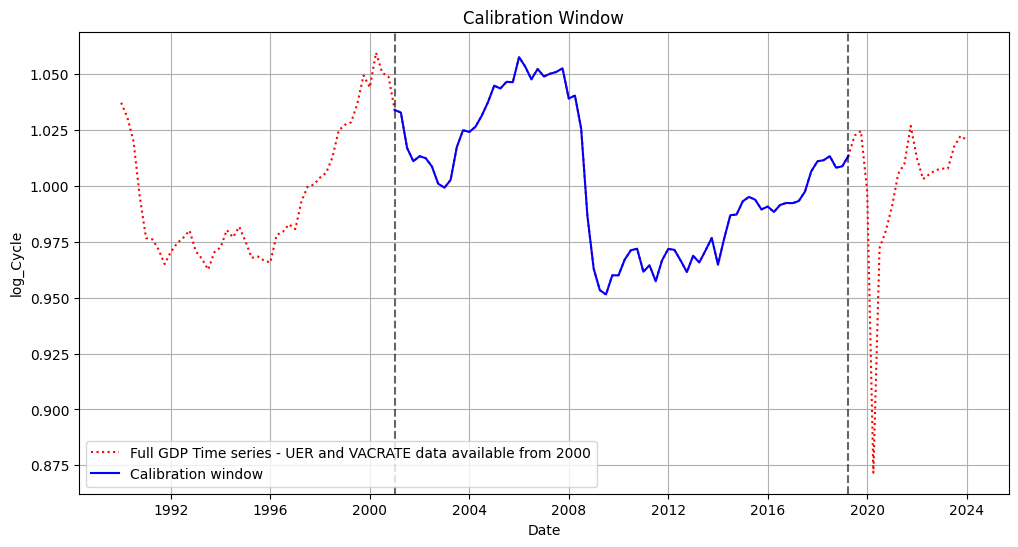

In [4]:
# Different calibration windows
# Full time series: "2024-5-1"
# calib_date = ["2004-12-01", "2019-05-01"]
calib_date = ["2000-12-01", "2019-05-01"]
# calib_date = ["2000-12-01", "2024-05-01"]
bus_conf_short = bus_conf_index[(bus_conf_index['DATE'] >= calib_date[0]) & (bus_conf_index['DATE'] <= calib_date[1])]
gdp_dat_pd = realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]
gdp_dat = np.array(gdp_dat_pd['log_Cycle'])
gdp_dat_bk = np.array(gdp_dat_pd['bk_gdp'])
gdp_dat_hamilton = np.array(gdp_dat_pd['hamilton_gdp'])
bus_conf_dat = np.array(bus_conf_short['OBS_VALUE_scaled'])

# PLOTTING
plt.figure(figsize=(12, 6))

# Plot original data
sns.lineplot(data = realgdp, x = 'DATE', y = 'log_Cycle', color = "red", label = "Full GDP Time series - UER and VACRATE data available from 2000", linestyle = "dotted")
sns.lineplot(data=gdp_dat_pd, x='DATE', y='log_Cycle', color='blue', label='Calibration window')

# Mark original data boundaries
plt.axvline(x=gdp_dat_pd['DATE'].min(), color='black', linestyle='--', alpha=0.6)
plt.axvline(x=gdp_dat_pd['DATE'].max(), color='black', linestyle='--', alpha=0.6)

plt.xlabel('Date')
plt.ylabel('log_Cycle')
plt.title('Calibration Window')
plt.legend()
plt.grid(True)
plt.show()

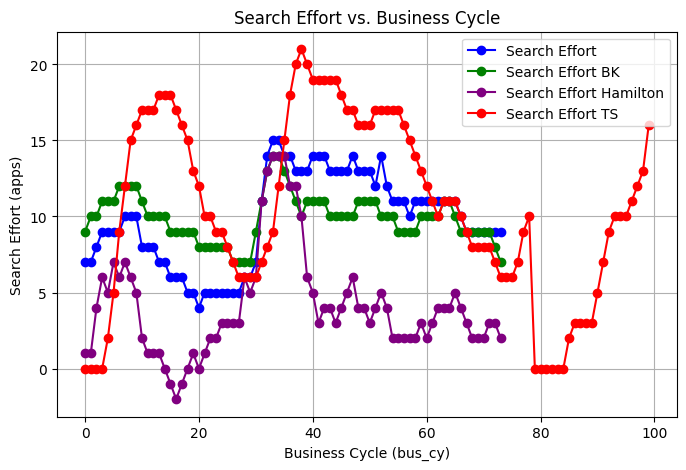

In [5]:
# Search Effort Time Series
search_effort_dat = pd.read_csv("data/quarterly_search_ts.csv")
search_effort_dat['DATE'] = pd.to_datetime(search_effort_dat['year'].astype(str) + '-' + (search_effort_dat['quarter'] * 3 - 2).astype(str) + '-01')
search_effort_np = np.array(search_effort_dat['value_smooth'])
search_effort_np = search_effort_np/search_effort_np.mean()
#realgdp[(realgdp['DATE'] >= calib_date[0]) & (realgdp['DATE'] <= calib_date[1])]

# Define a range of bus_cy values  # Generates 100 values from 0 to 1
search_effort_values = [search_effort(0, b, False) for b in gdp_dat]  # Apply function
search_effort_bk_values = [search_effort(0, b, False) for b in gdp_dat_bk]  # Apply function
search_effort_hamilton_values = [search_effort(0, b, False) for b in gdp_dat_hamilton]  # Apply function
# def search_effort_ts(t_unemp, se):
#     apps = max(0, round(10 - 100*(1-se)))
#     # if discouraged:
#     #     apps = round(a_stable/((t_unemp)**2 + 1)) + 1
#     return apps
search_effort_values_dyn = [search_effort_ts(0, b) for b in search_effort_np]

# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='b', label="Search Effort")
plt.plot(range(len(search_effort_bk_values)), search_effort_bk_values, marker='o', linestyle='-', color='g', label="Search Effort BK")
plt.plot(range(len(search_effort_hamilton_values)), search_effort_hamilton_values, marker='o', linestyle='-', color='purple', label="Search Effort Hamilton")

plt.plot(range(len(search_effort_values_dyn)), search_effort_values_dyn, marker='o', linestyle='-', color='r', label="Search Effort TS")
plt.xlabel("Business Cycle (bus_cy)")
plt.ylabel("Search Effort (apps)")
plt.title("Search Effort vs. Business Cycle")
plt.legend()
plt.grid(True)
plt.show()

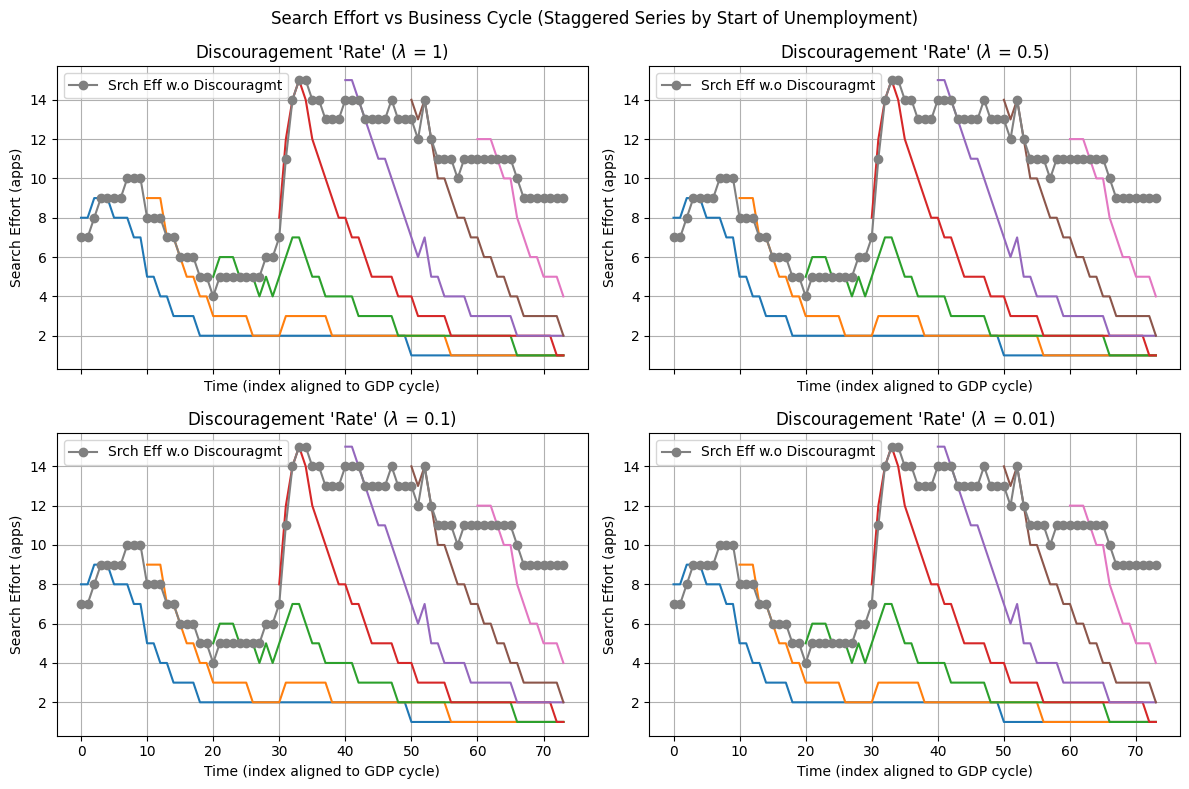

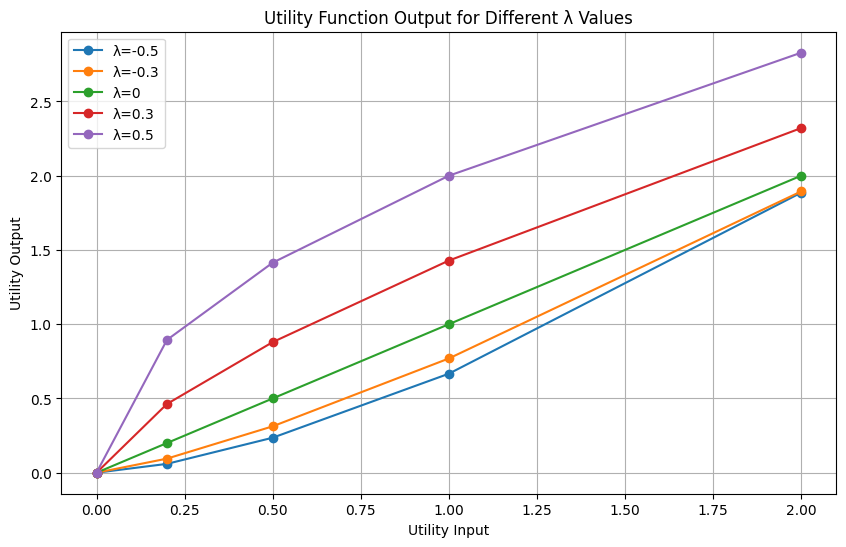

In [6]:
fig, axes = plt.subplots(2,2, figsize=(12, 8), sharex=True)
for i, a in enumerate([1, 0.5, 0.1, 0.01]):
    # def search_effort_unemp(t_unemp, bus_cy):
    #     apps = 10 + 100 * (1 - bus_cy)
    #     if t_unemp > 2:
    #         apps = round(apps / ((a*(t_unemp-2)) + 1)) + 1
    #     return apps

    # Let's define some arbitrary starting points
    start_points = [0, 10, 20, 30, 40, 50, 60]  # You can choose any index offsets
    series_dict = {}

    for start in start_points:
        efforts = []
        for t_unemp, bus_cy in enumerate(gdp_dat[start:]):
            apps = search_effort(t_unemp, bus_cy, True)
            efforts.append(apps)
        series_dict[f"Start @ {start}"] = {
            "x": list(range(start, start + len(efforts))),
            "y": efforts
        }

    # Plot
    ax = axes[i//2, i%2]
    for label, data in series_dict.items():
        ax.plot(data["x"], data["y"], linestyle='-')

    ax.plot(range(len(search_effort_values)), search_effort_values, marker='o', linestyle='-', color='grey', label="Srch Eff w.o Discouragmt")
    ax.set_title(f"Discouragement 'Rate' ($\lambda$ = {a})")
for ax in axes.flat:
    ax.set_xlabel("Time (index aligned to GDP cycle)")
    ax.set_ylabel("Search Effort (apps)")

    ax.legend(loc='upper left')
    ax.grid(True)
plt.suptitle("Search Effort vs Business Cycle (Staggered Series by Start of Unemployment)")
plt.tight_layout()
plt.show()


def utility_fun(lambda_param, utility):
    if lambda_param == 1:
        return(np.log(utility))
    else:
        return((utility**(1-lambda_param))/(1-lambda_param))

lambdas = [-0.5, -0.3, 0, 0.3, 0.5]
utilities = [0, 0.2, 0.5, 1, 2]

plt.figure(figsize=(10, 6))

for lambda_p in lambdas:
    utility_outputs = []
    for utility in utilities:
        utility_outputs.append(utility_fun(lambda_p, utility))
    plt.plot(utilities, utility_outputs, marker='o', label=f'λ={lambda_p}')

plt.xlabel('Utility Input')
plt.ylabel('Utility Output') 
plt.title('Utility Function Output for Different λ Values')
plt.grid(True)
plt.legend()
plt.show()



### Unemployed Search Effort Time Series

In [7]:
# Macro observations
observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset=["UNRATE", "VACRATE"]).reset_index()
# Load US_input data
A = pd.read_csv(path+"dRC_Replication/data/occupational_mobility_network.csv", header=None)
employment = round(pd.read_csv(path+"dRC_Replication/data/ipums_employment_2016.csv", header = 0).iloc[:, [4]]/10000)
# Crude approximation using avg unemployment rate of ~5% - should aim for occupation-specific unemployment rates
unemployment = round(employment*(0.05/0.95))
# Less crude approximation using avg vacancy rate - should still aim for occupation-specific vacancy rates
vac_rate_base = pd.read_csv(path+"dRC_Replication/data/vacancy_rateDec2000.csv").iloc[:, 2].mean()/100
vacancies = round(employment*vac_rate_base/(1-vac_rate_base))
# Needs input data...
demand_target = employment + vacancies
wages = pd.read_csv(path+"dRC_Replication/data/ipums_variables.csv")[['median_earnings']]
gend_share = pd.read_csv(path+"data/ipums_variables_w_gender.csv")[['women_pct']]
mod_data =  {"A": A, "employment": employment, 
             'unemployment':unemployment, 'vacancies':vacancies, 
             'demand_target': demand_target, 'wages': wages, 'gend_share': gend_share}

###################################
# Initialise the model
##################################
net_temp, vacs = initialise(len(mod_data['A']), mod_data['employment'].to_numpy(), mod_data['unemployment'].to_numpy(), mod_data['vacancies'].to_numpy(), mod_data['demand_target'].to_numpy(), mod_data['A'], mod_data['wages'].to_numpy(), mod_data['gend_share'].to_numpy(), 0, 0)

# observation = macro_observations.loc[(macro_observations['DATE'] >= calib_date[0]) & (macro_observations['DATE'] <= calib_date[1])].dropna(subset = ["UNRATE", "VACRATE"]).reset_index()
# Load calibrated parameters from CSV
param_df = pd.read_csv("output_23_04/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

params = {'mod_data': mod_data, 
            'net_temp': net_temp,
            'vacs': vacs, 
            'time_steps': len(gdp_dat),
            'delay': 0,
            'gdp_data': gdp_dat}


In [8]:
####################
# Model Run ########
####################
def run_single_local( #behav_spec, 
                    d_u, 
                    d_v,
                    gamma_u,
                    gamma_v,
                    otj,
                    cyc_otj, 
                    cyc_ue, 
                    disc,
                    mod_data = mod_data, 
                    net_temp = net_temp, 
                    vacs = vacs, 
                    time_steps = len(gdp_dat), # set equal to length of gdp_data
                    delay = 0,
                    gdp_data = gdp_dat,
                    bus_confidence_dat = gdp_dat,
                    simple_res = False):
    
    """ Runs the model once
    Argsuments:
       behav_spec: whether or not to run the behavioural model
       data: data required of initialise function  
       time_steps: Number of time steps for single model run
       d_u: parameter input to separation probability
       d_v: parameter input to vacancy opening probability

    Returns:
       dataframe of model run results
    """
    # Records variables of interest for plotting
    # Initialise deepcopy occupational mobility network
    #print(behav_spec)
    record = [] 
    #print(parameter['vacs'])
    vacs_temp = deepcopy(vacs)
    net = deepcopy(net_temp)

    for t in range(time_steps):
        #if t == 1:
            #print(behav_spec)
        curr_bus_cy = gdp_data[t]
        bus_conf = bus_confidence_dat[t]
        ue_bc = curr_bus_cy
        if not cyc_ue:
            ue_bc = 1
        # search_eff_curr = search_eff_ts[t]
        # Ensure number of workers in economy has not changed
        #tic = time.process_time()
        emp_seekers = 0
        unemp_seekers = 0
        for occ in net:
            ### APPLICATIONS
            # Questions to verify:
            # - CANNOT be fired and apply in same time step ie. time_unemployed > 0
            # - CAN be rejected and apply in the same time step - no protected attribute
            # isolate list of vacancies in economy that are relevant to the occupation
            # - avoids selecting in each search_and_apply application
            r_vacs = [vac for vac in vacs_temp if occ.list_of_neigh_bool[vac.occupation_id]]          
    
            for u in occ.list_of_unemployed:
                unemp_seekers += 1
                # this one if only using simple scaling factor for the search effort
                u.search_and_apply(net, r_vacs, disc, ue_bc)
                # use the following if we wish to incorporate the entire TS of search effort
                #u.search_and_apply(net, r_vacs, behav_spec, search_eff_curr)
            
            if otj:
                # For both models, a mean of 40% of employed workers are searching for new jobs
                # This fluctuates with the business cycle in the behavioural model in line with gdp
                if cyc_otj:
                    search_scaling = curr_bus_cy*0.07
                # Static mean in the non-behavioural model
                else:
                    search_scaling = 0.07
                for e in random.sample(occ.list_of_employed, int(search_scaling*len(occ.list_of_employed))):
                    emp_seekers += 1
                    e.emp_search_and_apply(net, r_vacs)

            ### SEPARATIONS
            try:
                occ.separate_workers(d_u, gamma_u, curr_bus_cy)
            except Exception as e:
                return np.inf

        ### HIRING
        # Ordering of hiring randomised to ensure list order does not matter in filling vacancies...
        # Possibly still introduces some bias...this seems to be where the "multiple offer" challenge Maria mentioned comes from
        # ....might be better to do this using an unordered set?
        for v_open in sorted(vacs_temp,key=lambda _: random.random()):
            # Removes any applicants that have already been hired in another vacancy
            v_open.applicants[:] = [app for app in v_open.applicants if not(app.hired)]
            v_open.time_open += 1
            if len(v_open.applicants) > 0:
                v_open.hire(net)
                v_open.filled = True
                #vacs.remove(v_open)
                assert(len(v_open.applicants) == 0)
            else:
                pass

        vacs_temp = [v for v in vacs_temp if not(v.filled) and v.time_open <= 1] 

        # # Reset counters for record in time t
        # empl = 0 
        # unemp = 0
        # n_ltue = 0
        # curr_demand = 0
        # t_demand = 0

        ### OPEN VACANCIES
        # Update vacancies after all shifts have taken place
        # Could consider making this a function of the class itself?
        for occ in net:
            u_rel_wage = sum(wrkr.ue_rel_wage for wrkr in occ.list_of_employed if wrkr.hired and wrkr.ue_rel_wage is not None)
            e_rel_wage = sum(wrkr.ee_rel_wage for wrkr in occ.list_of_employed if wrkr.hired and wrkr.ee_rel_wage is not None)
            ue = len([w for w in occ.list_of_employed if w.hired and w.ue_rel_wage is not None])
            ee = len([w for w in occ.list_of_employed if w.hired and w.ee_rel_wage is not None])
            # Update time_unemployed and long-term unemployed status of unemployed workers
            # Remove protected "hired" attribute of employed workers
            occ.update_workers()
            # Assert that all unemployed people have spent 1 or more time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_unemployed]) == 0)
            # Assert that all employed people have spent 0 time periods unemployed
            assert(sum([worker.time_unemployed <= 0 for worker in occ.list_of_employed]) == len(occ.list_of_employed))
            emp = len(occ.list_of_employed)
            occ.current_demand = (len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp)
            #occ.current_demand = bus_cycle_demand(len([v_open for v_open in vacs_temp if v_open.occupation_id == occ.occupation_id]) + emp, t, bus_amp, bus_cycle_len)
            vac_prob = d_v + ((gamma_v * max(0, occ.target_demand*(bus_conf) - occ.current_demand)) / (emp + 1))
            #vac_prob = d_v + ((1 - d_v) * (gamma_v * max(0, occ.target_demand - occ.current_demand))) / (emp + 1)
            vacs_create = emp*int(vac_prob) + int(np.random.binomial(emp, vac_prob%1))
            for v in range(vacs_create):
                vacs_temp.append(vac(occ.occupation_id, [], occ.wage, False, 0))

            empl = len(occ.list_of_employed) 
            unemp = len(occ.list_of_unemployed)
            n_ltue = sum(wrkr.longterm_unemp for wrkr in occ.list_of_unemployed)
            curr_demand = occ.current_demand
            t_demand = occ.target_demand*bus_conf
            vacs_occ = len([v for v in vacs_temp if v.occupation_id == occ.occupation_id])
            wages_occ = sum(wrkr.wage for wrkr in occ.list_of_employed)
            # Calculate average relative wage for unemployed and employed workers


            ### UPDATE INDICATOR RECORD
            record.append([t+1, occ.occupation_id, empl, unemp, empl + unemp, vacs_occ, n_ltue, curr_demand, t_demand, emp_seekers, unemp_seekers, wages_occ, u_rel_wage, e_rel_wage, ue, ee])
            # record = np.append(record, 
            #                         np.array([[t+1, occ.occupation_id, empl, unemp, empl + unemp, len(vacs_temp), n_ltue, curr_demand, t_demand, emp_seekers, unemp_seekers]]), 
            #                         axis = 0)

    record_df = pd.DataFrame(record, columns=['Time Step', 'Occupation', 'Employment', 'Unemployment', 'Workers', 'Vacancies', 'LT Unemployed Persons', 'Current_Demand', 'Target_Demand', 'Employed Seekers', 'Unemployed Seekers', 'Total_Wages', 'U_Rel_Wage', 'E_Rel_Wage', 'UE_Transitions', 'EE_Transitions'])
    grouped = record_df.groupby('Time Step').sum().reset_index()

    grouped['UER'] = grouped['Unemployment'] / grouped['Workers']
    grouped['U_REL_WAGE_MEAN'] = grouped['U_Rel_Wage'] / grouped['UE_Transitions']
    grouped['E_REL_WAGE_MEAN'] = grouped['E_Rel_Wage'] / grouped['EE_Transitions']
    grouped['UE_Trans_Rate'] = grouped['UE_Transitions'] / grouped['Workers']
    grouped['EE_Trans_Rate'] = grouped['EE_Transitions'] / grouped['Workers']
    #grouped['VACRATE1'] = grouped['Vacancies'] / (grouped['Current_Demand'])
    grouped['VACRATE'] = grouped['Vacancies'] / (grouped['Vacancies'] + grouped['Employment'])

    data = {'UER': grouped['UER'], 'VACRATE': grouped['VACRATE']}

    if simple_res:
        return data
    else:
        return record_df, grouped, net, data

#########################################
# Wrapper for pyabc ########
#########################################
def pyabc_run_single(parameter):     
    res = run_single_local(**parameter)
    return res 
    

In [9]:
calib_list = {
    # "nonbehav": {"otj": False, # has been run
    #                        "cyc_otj": False, 
    #                        "cyc_ue": False, 
    #                        "disc": False,
    #                        "bus_confidence_dat": gdp_dat},
              "otj_nonbehav": {"otj": True, # has been run
                           "cyc_otj": False, 
                           "cyc_ue": False, 
                           "disc": False, 
                           "bus_confidence_dat": gdp_dat},
            #   "otj_cyclical_e": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": False, 
            #                "disc": False,
            #                "bus_confidence_dat": gdp_dat},
            #   "otj_cyclical_ue": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": False,
            #                "bus_confidence_dat": gdp_dat},
            #   "otj_cyclical_e_ue": {"otj": True,
            #                "cyc_otj": True, 
            #                "cyc_ue": True, 
            #                "disc": False,
            #                "bus_confidence_dat": gdp_dat},
              "otj_cyclical_e_disc": {"otj": True,
                           "cyc_otj": True, 
                           "cyc_ue": False, 
                           "disc": True,
                           "bus_confidence_dat": gdp_dat}
            #   "otj_cyclical_ue_disc": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": True, 
            #                "disc": True,
            #                "bus_confidence_dat": gdp_dat},
              # "otj_cyclical_e_ue_disc": {"otj": True,
              #              "cyc_otj": True, 
              #              "cyc_ue": True, 
              #              "disc": True,
              #              "bus_confidence_dat": gdp_dat},
            #  "otj_disc": {"otj": True,
            #                "cyc_otj": False, 
            #                "cyc_ue": False, 
            #                "disc": True,
            #                "bus_confidence_dat": gdp_dat}
            }

In [10]:
# Initialize the results dictionaries
model_results = {}
net_results = {}
sim_results = {}
sum_stats_list = {}

# Loop through each model configuration
for name, item in calib_list.items():
    print(name)
    # Create a deep copy of the base parameters
    test_params = deepcopy(params)

    # Update with values from param_df specific to the current model name
    if name in param_df['model_cat'].values:
        param_updates = param_df[param_df['model_cat'] == name].set_index('Parameter')['Value'].to_dict()
        print(param_updates)
        test_params.update(param_updates)

    # Update with the values from the calib_list
    test_params.update(item)

    # Run the model
    sim_record, sim_grouped, sim_net, sum_stats = run_single_local(**test_params)

    # Generate plots or metrics (optional step)
    #ue_vac = plot_records(sim_record, calib_date[0], calib_date[1])
    sim_grouped['DATE'] = pd.date_range(start=calib_date[0], end= calib_date[1], periods=len(sim_grouped))
    sim_grouped['LTUE Rate'] = sim_grouped['LT Unemployed Persons'] / sim_grouped['Unemployment']
    sim_grouped['AVGWAGE'] = sim_grouped['Total_Wages'] / sim_grouped['Employment']
    sim_record['LTUE Rate'] = sim_record['LT Unemployed Persons'] / sim_record['Unemployment']
    sim_record['UER'] = sim_record['Unemployment'] / sim_record['Workers']
    sim_record['AVGWAGE'] = sim_record['Total_Wages'] / sim_record['Employment']
    sim_record['VACRATE1'] = sim_record['Vacancies'] / sim_record['Target_Demand']
    sim_record['VACRATE'] = sim_record['Vacancies'] / (sim_record['Vacancies'] + sim_record['Employment'])
    sim_record['U_REL_WAGE_MEAN'] = sim_record['U_Rel_Wage'] / sim_record['UE_Transitions']
    sim_record['E_REL_WAGE_MEAN'] = sim_record['E_Rel_Wage'] / sim_record['EE_Transitions']
    sim_record['UE_Trans_Rate'] = sim_record['UE_Transitions'] / sim_record['Workers']
    sim_record['EE_Trans_Rate'] = sim_record['EE_Transitions'] / sim_record['Workers']


    # Store the results
    model_results[name] = sim_grouped
    sim_results[name] = sim_record
    net_results[name] = sim_net
    sum_stats_list[name] = sum_stats


otj_nonbehav
{'gamma_v': 0.086849474977631, 'gamma_u': 0.8500644192587314, 'd_v': 0.0284882856043, 'd_u': 0.0162988564424403}
otj_cyclical_e_disc
{'gamma_v': 0.2521616733566374, 'gamma_u': 0.7414248062670183, 'd_v': 0.0167843781656679, 'd_u': 0.0091877106374601}


463


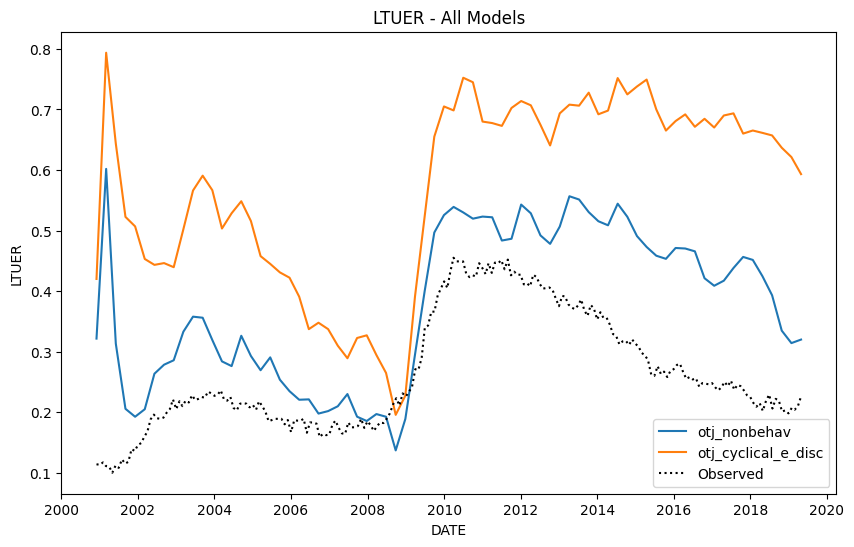

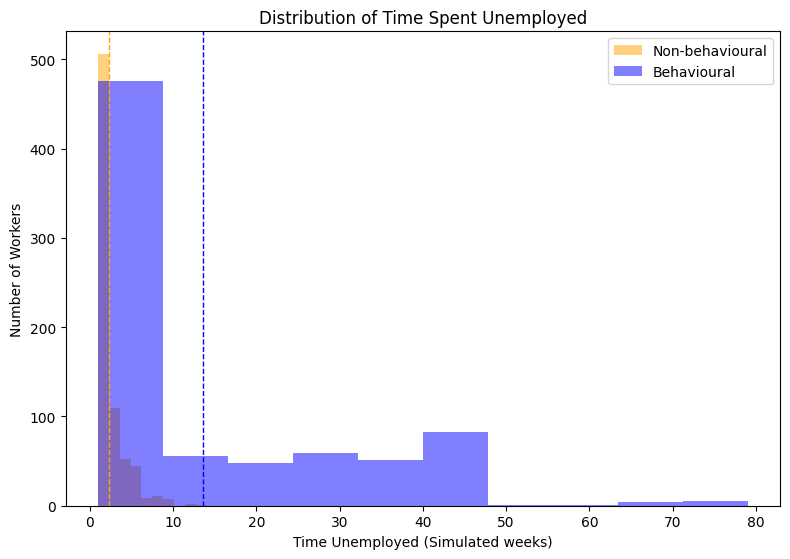

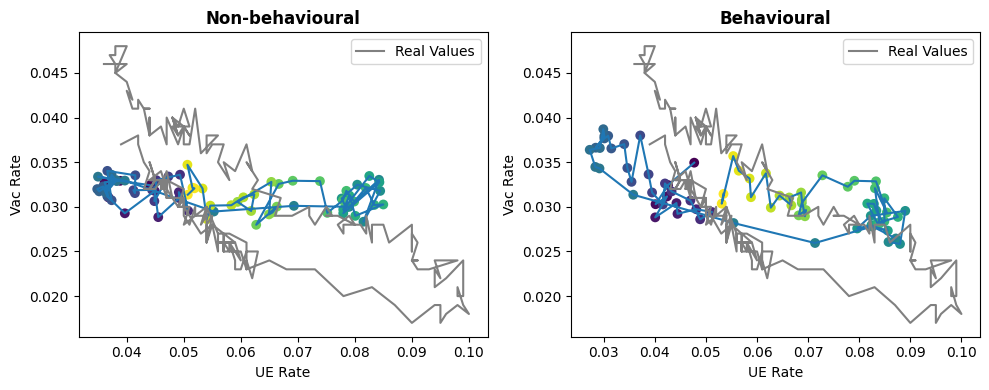

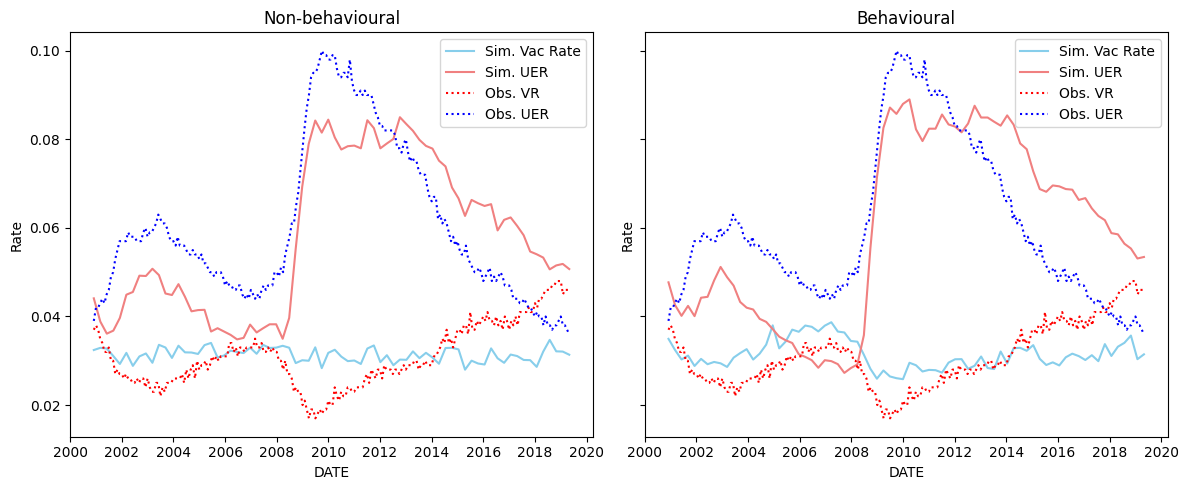

0


In [ ]:
filtered_model_results = {key: model_results[key] for key in ["otj_nonbehav", "otj_cyclical_e_disc"] if key in model_results}
filtered_net_results = {key: net_results[key] for key in ["otj_nonbehav", "otj_cyclical_e_disc"] if key in net_results}
filtered_sim_results = {key: sim_results[key] for key in ["otj_nonbehav", "otj_cyclical_e_disc"] if key in sim_results}
filtered_sum_stats = {key: sum_stats_list[key] for key in ["otj_nonbehav", "otj_cyclical_e_disc"] if key in sum_stats_list}

plot_ltuer(filtered_model_results, observation)
# plot_bev_curve(filtered_model_results, observation)
# plot_uer_vac(filtered_model_results, observation)
# plot_seeker_comp(filtered_model_results, share = True)
#plot_gender_gaps(filtered_net_results)

plot_ltuer_dist(filtered_net_results, gender = False, names = ["Non-behavioural", "Behavioural"])
plot_bev_curve(filtered_model_results, observation, sep_strings = [("nonbehav", "Non-behavioural"), ("disc", "Behavioural")], sep = True)
plot_uer_vac(filtered_model_results, observation, sep_strings = [("nonbehav", "Non-behavioural"), ("disc", "Behavioural")], sep = True)

print(filtered_net_results['otj_nonbehav'][0].occupation_id)

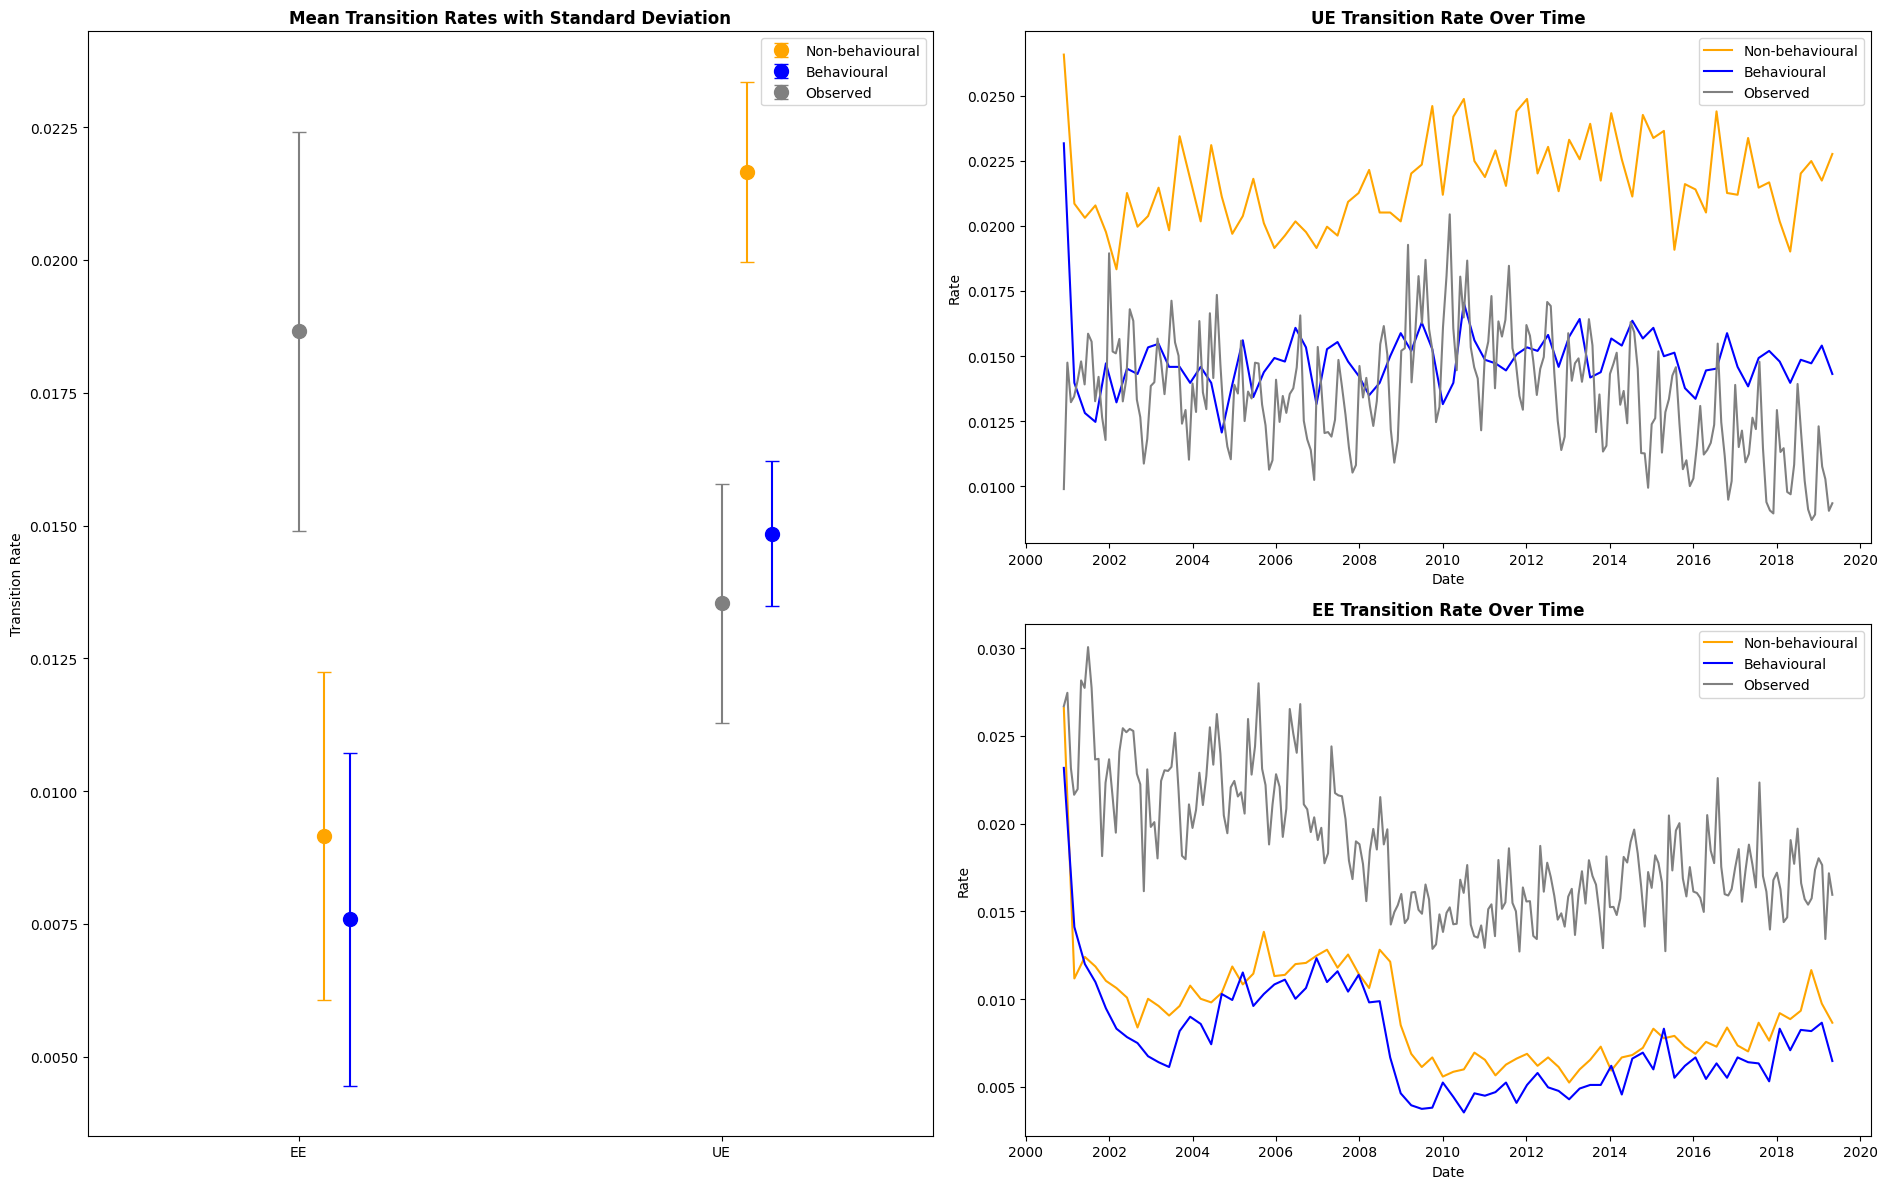

/Users/ebbamark/Documents/Documents - Nuff-Malham/GitHub/transition_abm/calibration_remote/plot_funs.py:306: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  annual_data = res.set_index('DATE').resample('Y').mean()


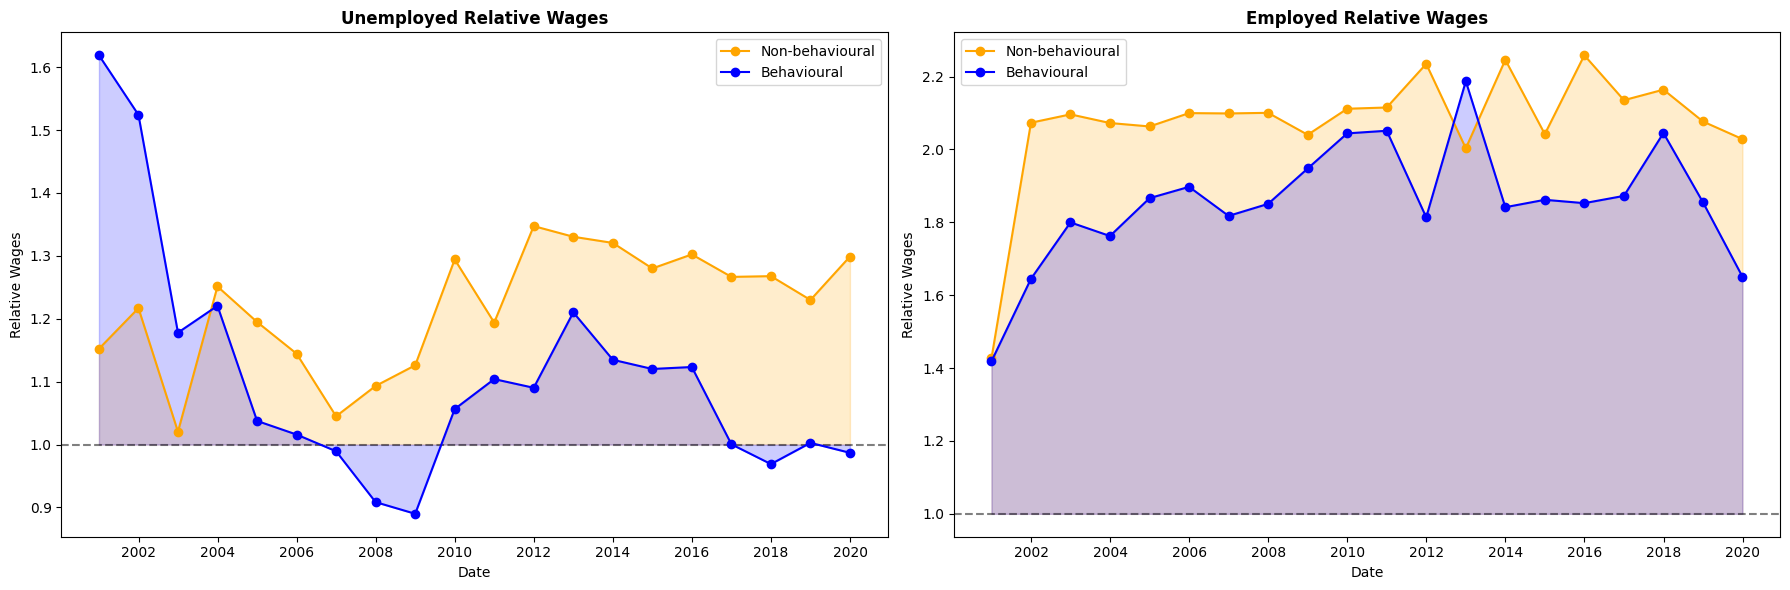

In [12]:

# moved to macro-vars folder from  data/behav_params/Eeckhout_Replication/cps_data/transition_rates_96_24.csv' - created in grouped_transition_rates.R script
all_rates_new = pd.read_csv('data/transition_rates_96_24.csv')
all_rates_new = all_rates_new[(all_rates_new['date'] >= calib_date[0]) & (all_rates_new['date'] <= calib_date[1])]
all_rates_new['DATE'] = pd.to_datetime(all_rates_new['date'])

plot_trans_rates(filtered_model_results, observation = all_rates_new, names = ["Non-behavioural", "Behavioural"])
plot_rel_wages(filtered_model_results, names = ["Non-behavioural", "Behavioural"])



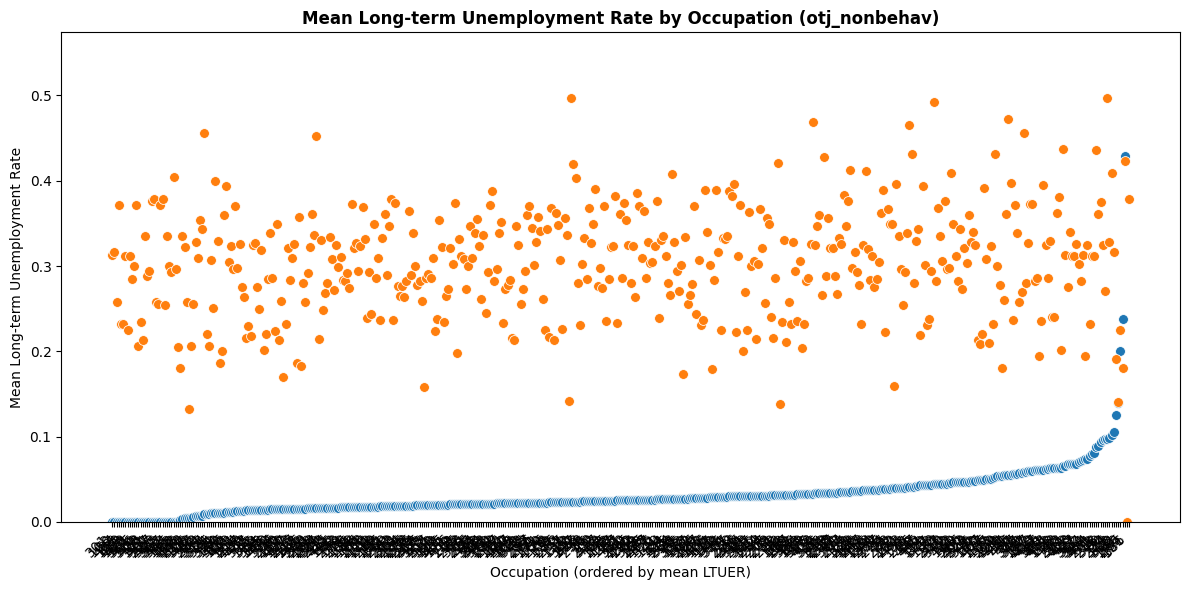

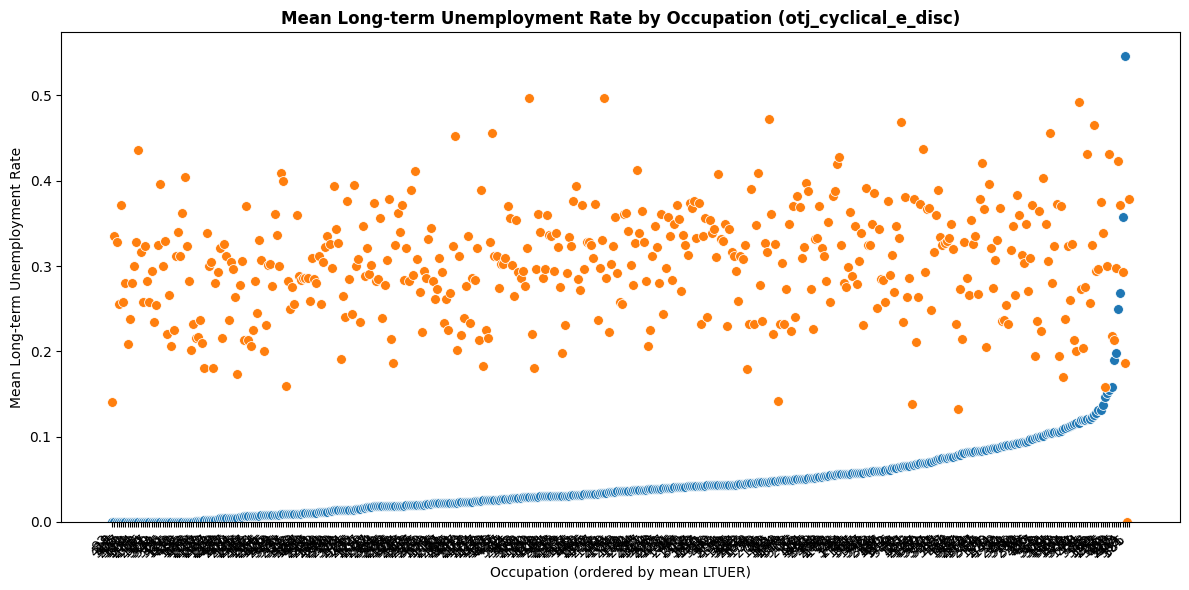

KeyError: 'LTUER'

In [13]:
# Example usage:
occ_ltuers = pd.read_csv(path+"data/highlev_occ_ltuers.csv")
occ_ltuers = occ_ltuers.groupby('occupation')['ltuer'].mean().reset_index()
# Pasted from data/occ_macro_vars/CPS_LTUER/occ_ltuer_observed.csv
occ_ltuer_obs = pd.read_csv(path + "data/occ_ltuer_observed.csv")

import plot_funs
importlib.reload(plot_funs)
from plot_funs import *


plot_occupation_ltuer(filtered_sim_results, occ_ltuer_obs)
plot_ltuer_difference_heatmap(filtered_sim_results, 
                              occ_ltuer_obs, 
                              difference_type='absolute', save=False, path=path)


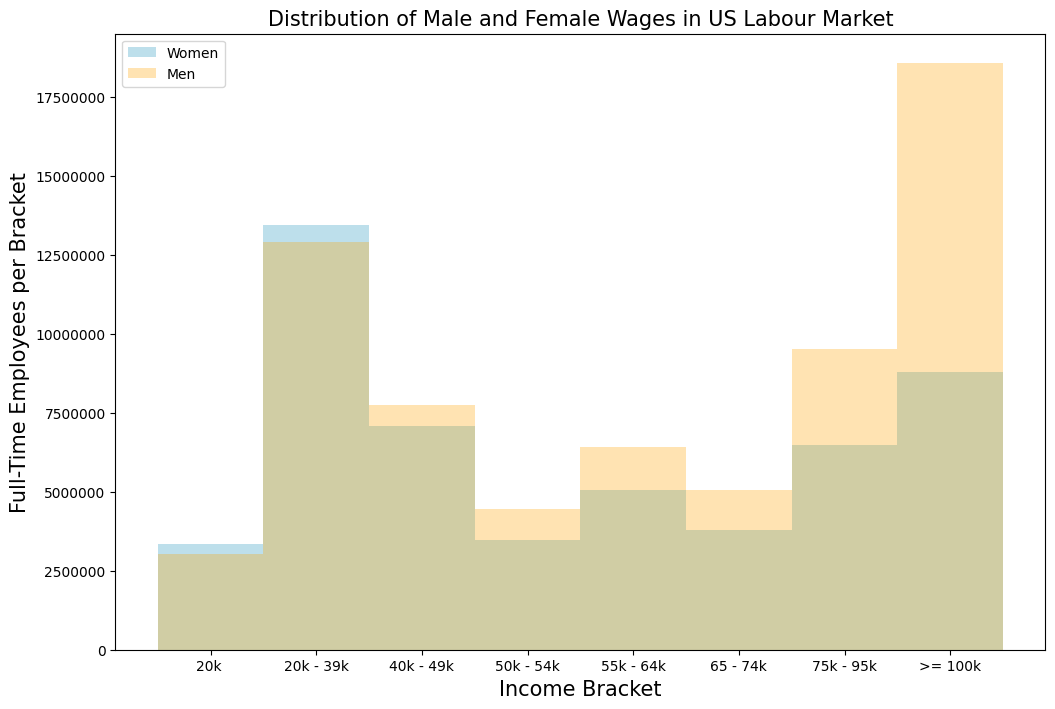

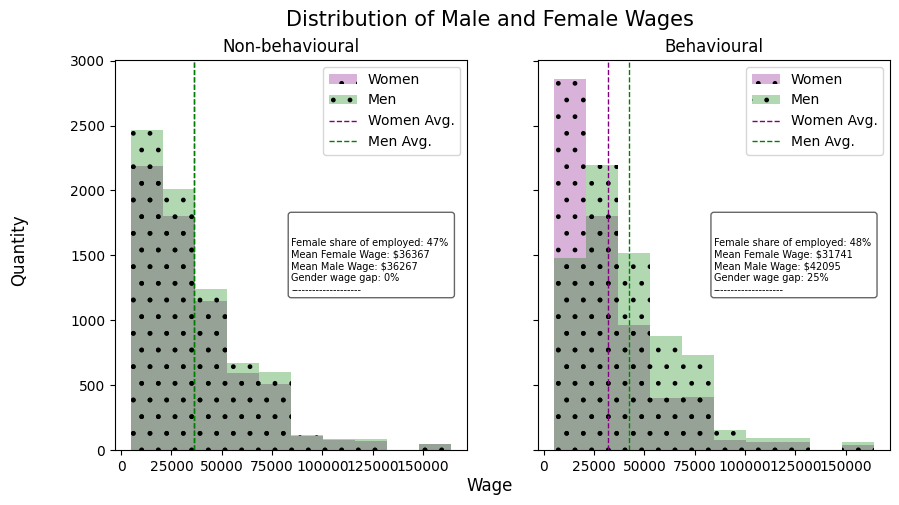

In [103]:

gender_income = pd.read_csv(path+"data/gender_income_distribution_usa_2022.csv", delimiter=',', thousands = ",")

gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or loss', '')
gender_income['Income Bracket'] = gender_income['Income Bracket'].str.replace(' or more', '')
gender_income['Ceiling'] = gender_income['Income Bracket'].str[-7:]
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(',', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace('$', '')
gender_income['Ceiling'] = gender_income['Ceiling'].str.replace(' ', '')
gender_income['Ceiling'] = gender_income['Ceiling'].astype('Int64')
gender_income.loc[0:7, 'Bracket'] = "20k "
gender_income.loc[8:12, 'Bracket'] = "20k - 39k"
gender_income.loc[13:14, 'Bracket'] = "40k - 49k"
gender_income.loc[15, 'Bracket'] = "50k - 54k"
gender_income.loc[16, 'Bracket'] = "55k - 64k"
gender_income.loc[17, 'Bracket'] = "65 - 74k"
gender_income.loc[18, 'Bracket'] = "75k - 95k"
gender_income.loc[19, 'Bracket'] = ">= 100k"
brackets = gender_income.groupby(['Bracket']).sum().reset_index()

barWidth = 1
fig = plt.subplots(figsize =(12, 8)) 
br1 = np.arange(len(brackets['Bracket'])) + 1
br2 = br1
 
# Make the plot
plt.bar(br1, brackets['Full-Time Females'], color ='lightblue', width = barWidth, alpha = 0.8,
         label ='Women') 
plt.bar(br2, brackets['Full-Time Males'], color ='orange', width = barWidth, alpha = 0.3,
        label ='Men') 


# Adding Xticks 
plt.xlabel('Income Bracket', fontsize = 15) 
plt.ylabel('Full-Time Employees per Bracket', fontsize = 15) 
plt.ticklabel_format(useOffset=False, style='plain')
plt.xticks([r + barWidth for r in range(len(brackets['Bracket']))], 
        brackets['Bracket'])

plt.title('Distribution of Male and Female Wages in US Labour Market', fontsize = 15) 
plt.legend()
plt.show() 

womens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Females']).sum()/(gender_income['Full-Time Females'].sum())
mens_wage = (gender_income['Ceiling'] * gender_income['Full-Time Males']).sum()/(gender_income['Full-Time Males'].sum())

plot_gender_gaps(filtered_net_results, names = ["Non-behavioural", "Behavioural"])



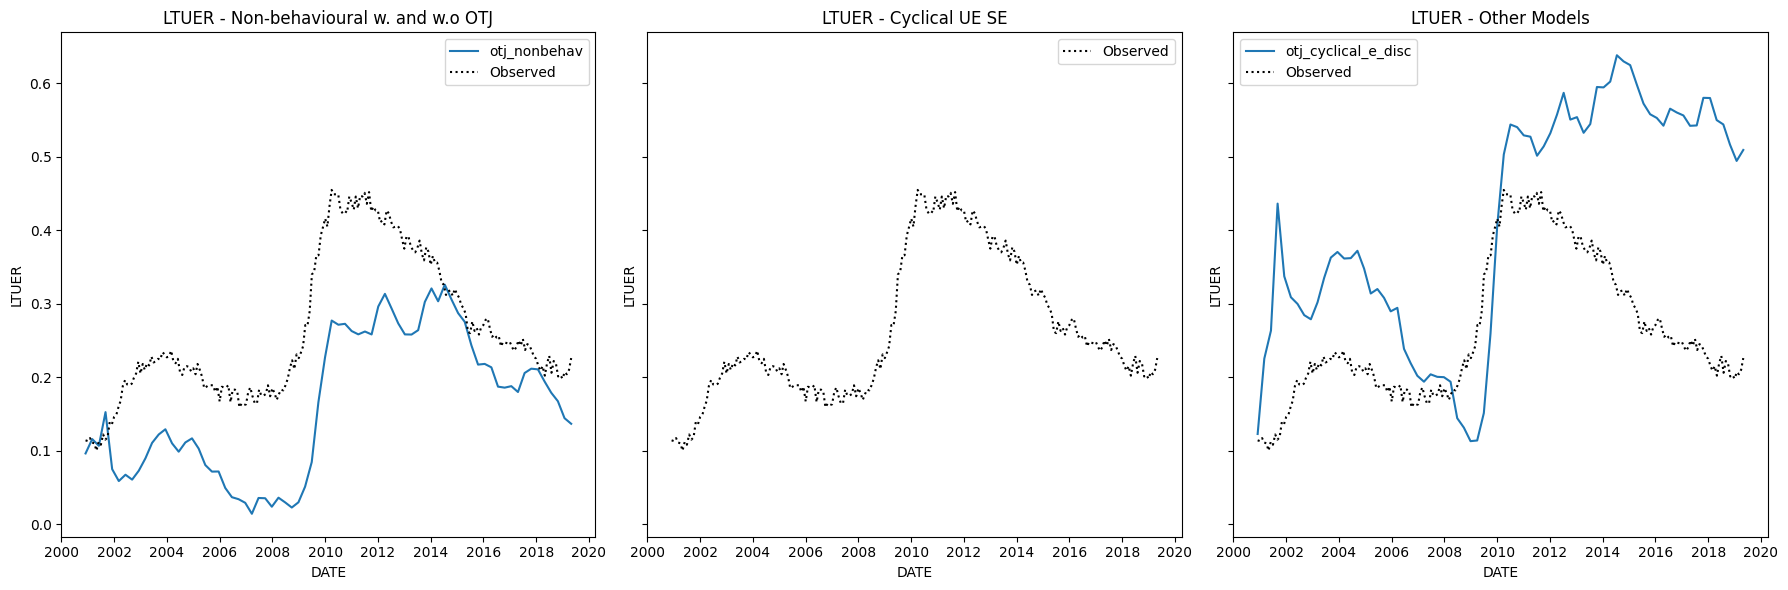

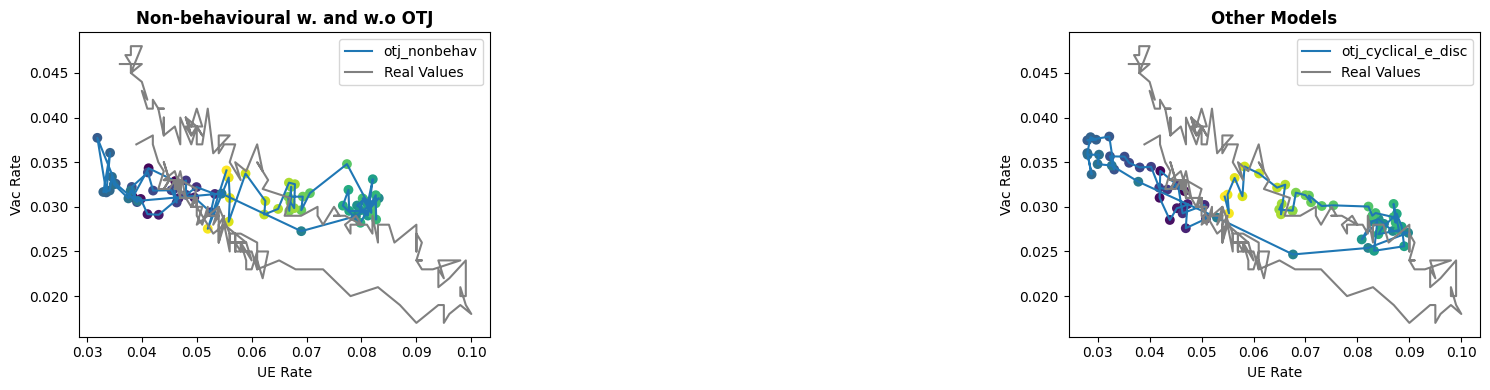

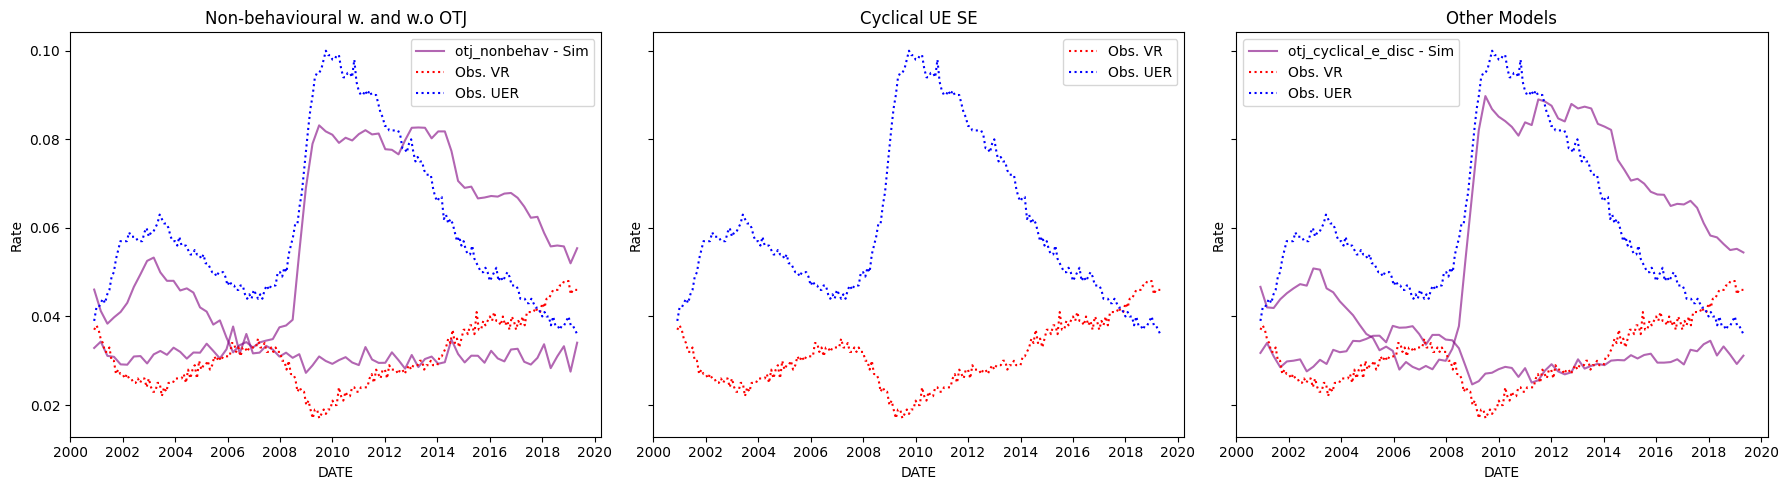

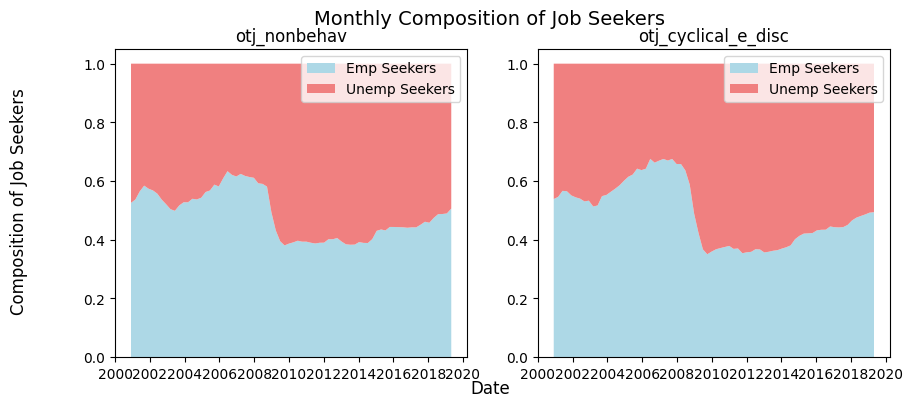

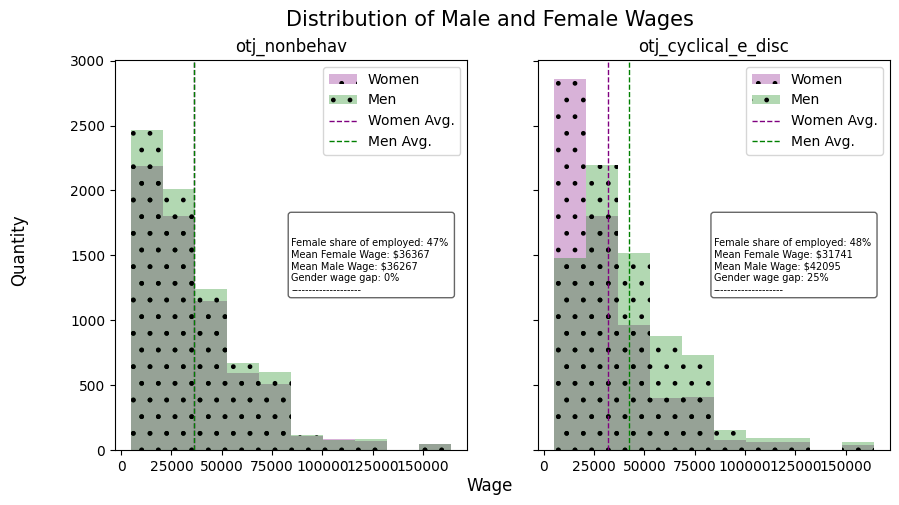

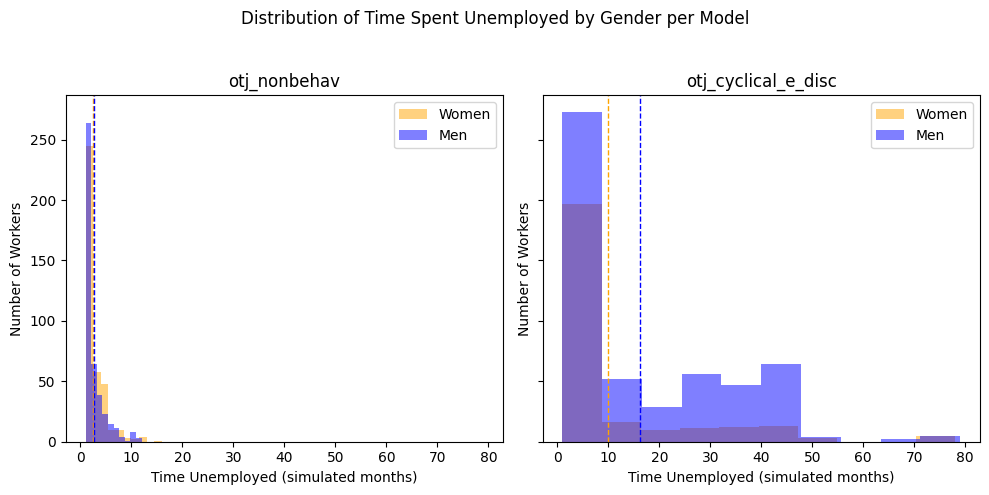

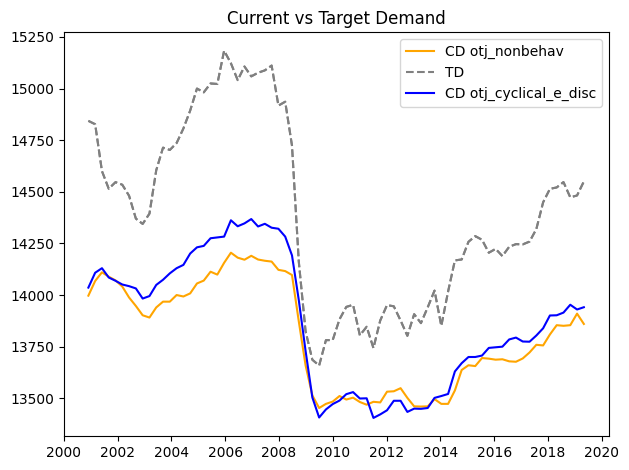

In [15]:
####################################################
############## CURRENT VS TARGET DEMAND ############
####################################################
plot_ltuer(model_results, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("ue", "Cyclical UE SE")], sep = True)
plot_bev_curve(model_results, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("ue", "Cyclical UE SE")], sep = True)
plot_uer_vac(model_results, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("ue", "Cyclical UE SE")], sep = True)
plot_seeker_comp(model_results, share = True)
plot_gender_gaps(net_results)
plot_ltuer_dist(net_results, gender = True)
plot_cd_vs_td(model_results)


In [16]:
# Initialize the results dictionaries
model_results_bc = {}
sim_results_bc = {}
net_results_bc = {}
sum_stats_list_bc = {}

param_df = pd.read_csv("output_23_04/calibration_bus_conf/calibrated_params_all.csv")
# Sort by Timestamp in descending order
param_df = param_df.sort_values(by='Timestamp', ascending=False)

# Loop through each model configuration
for name, item in calib_list.items():
    print(name)
    # Create a deep copy of the base parameters
    test_params = deepcopy(params)

    # Update with values from param_df specific to the current model name
    if name in param_df['model_cat'].values:
        param_updates = param_df[param_df['model_cat'] == name].set_index('Parameter')['Value'].to_dict()
        print(param_updates)
        test_params.update(param_updates)

    # Update with the values from the calib_list
    test_params.update(item)
    test_params.update({"bus_confidence_dat": bus_conf_dat})

    # Run the model
    sim_record, sim_grouped, sim_net, sum_stats = run_single_local(**test_params)

    # Generate plots or metrics (optional step)
    #ue_vac = plot_records(sim_record, calib_date[0], calib_date[1])
    sim_grouped['DATE'] = pd.date_range(start=calib_date[0], end= calib_date[1], periods=len(sim_grouped))
    sim_grouped['LTUE Rate'] = sim_grouped['LT Unemployed Persons'] / sim_grouped['Unemployment']
    sim_record['LTUE Rate'] = sim_record['LT Unemployed Persons'] / sim_record['Unemployment']
    sim_record['UER'] = sim_record['Unemployment'] / sim_record['Workers']
    sim_record['VACRATE1'] = sim_record['Vacancies'] / sim_record['Target_Demand']
    sim_record['VACRATE'] = sim_record['Vacancies'] / (sim_record['Vacancies'] + sim_record['Employment'])


    # Store the results
    model_results_bc[name] = sim_grouped
    sim_results_bc[name] = sim_record
    net_results_bc[name] = sim_net
    sum_stats_list_bc[name] = sum_stats


otj_nonbehav
{'d_v': 0.0148755289462075, 'gamma_v': 0.2791918689118575, 'gamma_u': 1.065521784645858, 'd_u': 0.0183907550136618}
otj_cyclical_e_disc
{'gamma_v': 0.3454795089049758, 'gamma_u': 0.6348686093106638, 'd_u': 0.0123002480165989, 'd_v': 0.0069200685221947}


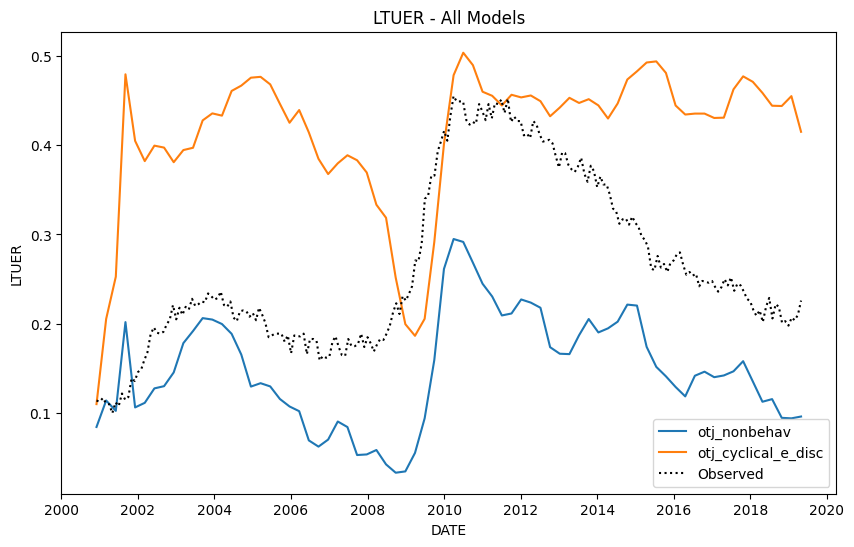

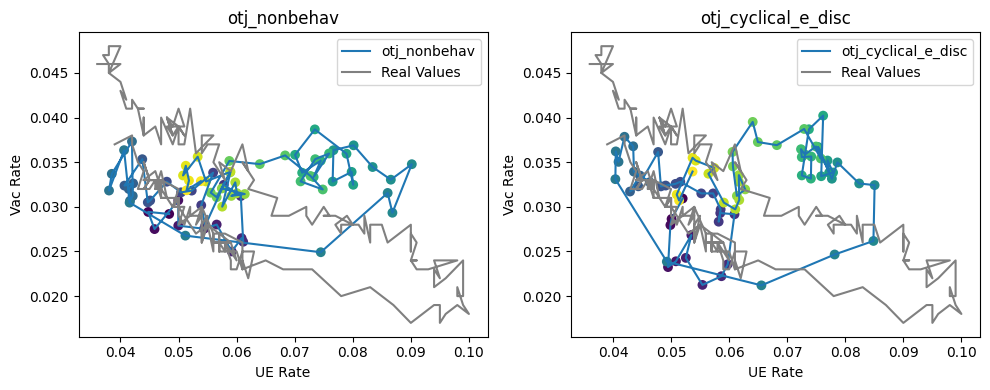

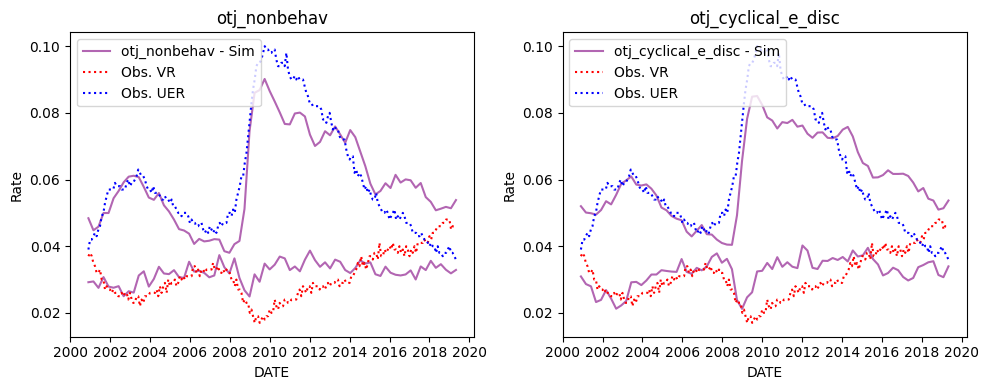

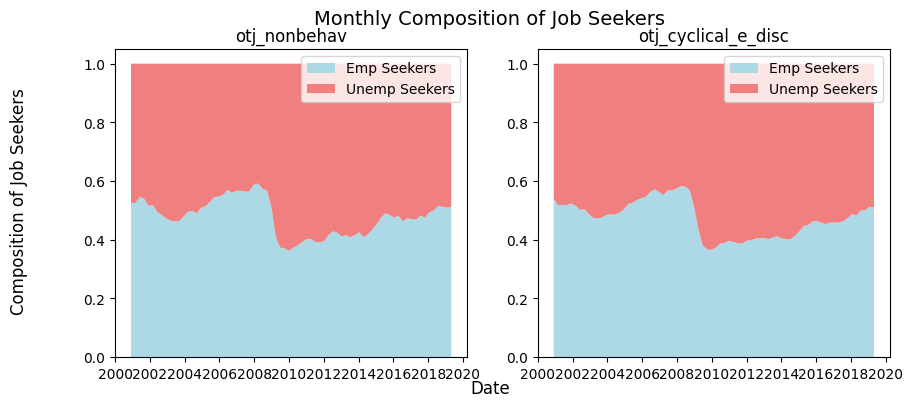

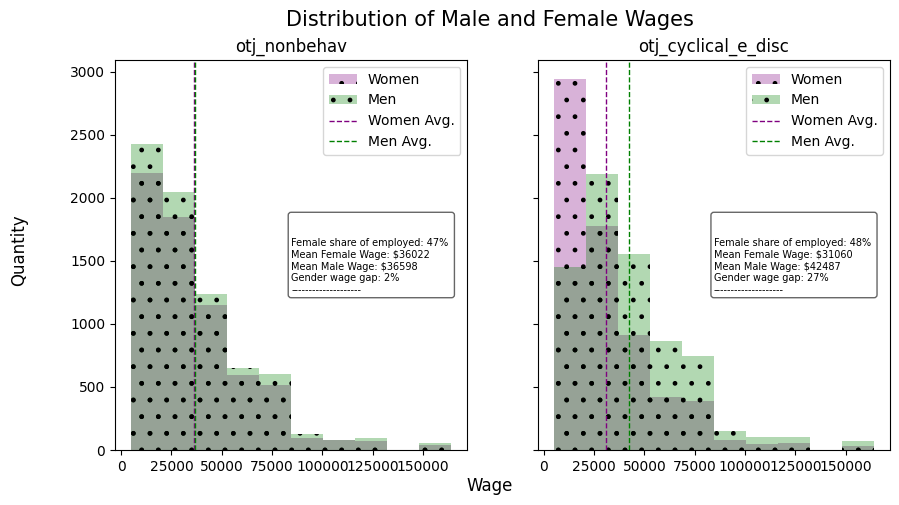

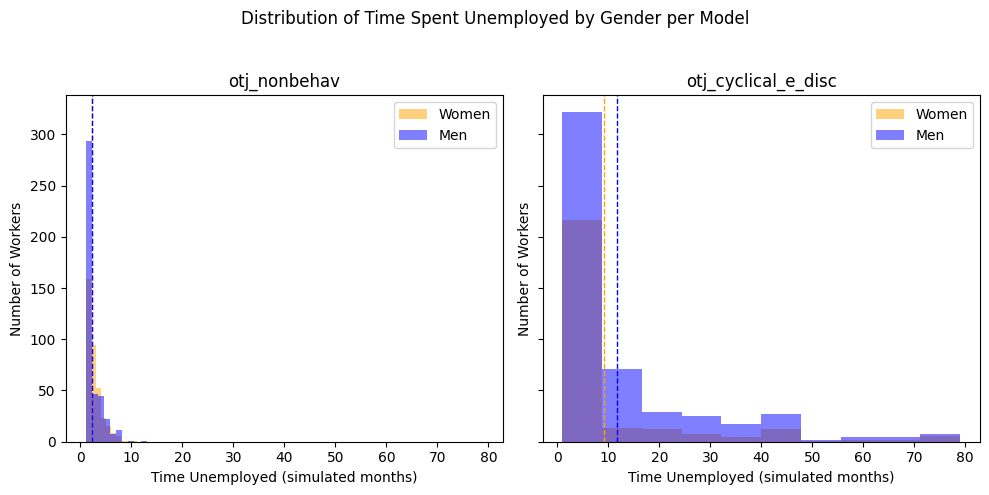

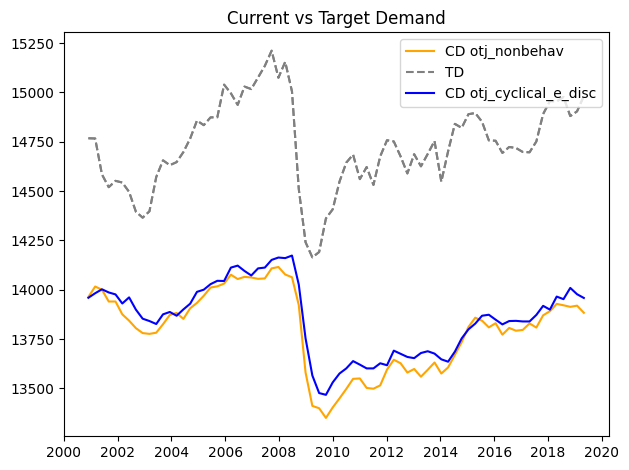

In [17]:
filtered_results_bc = {key: model_results_bc[key] for key in ["otj_nonbehav", "otj_cyclical_e_disc"] if key in model_results_bc}
filtered_net_results_bc = {key: net_results_bc[key] for key in ["otj_nonbehav", "otj_cyclical_e_disc"] if key in net_results_bc}

plot_ltuer(filtered_results_bc, observation)
plot_bev_curve(filtered_results_bc, observation)
plot_uer_vac(filtered_results_bc, observation)
plot_seeker_comp(filtered_results_bc, share = True)
plot_gender_gaps(filtered_net_results_bc)
plot_ltuer_dist(filtered_net_results_bc, gender = True)
plot_cd_vs_td(filtered_results_bc)

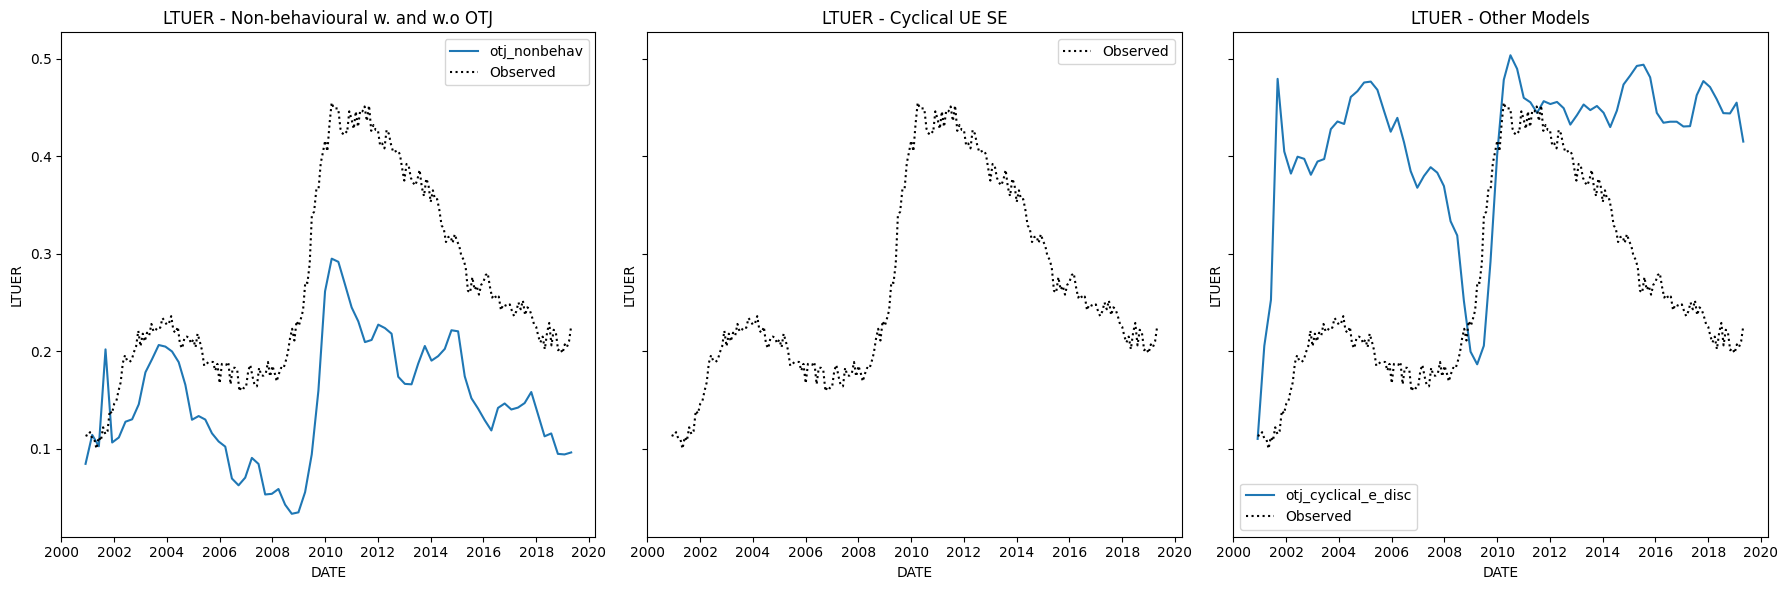

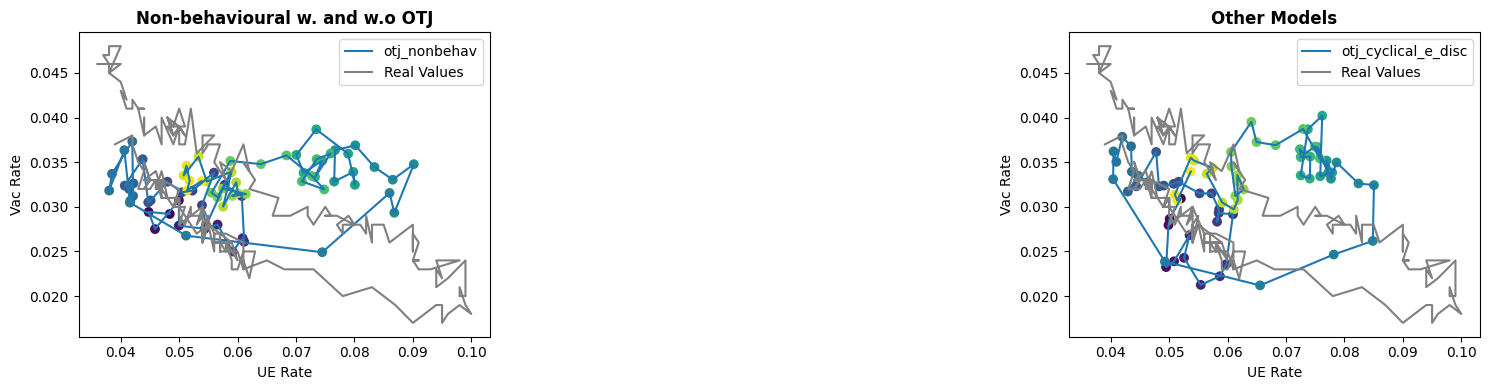

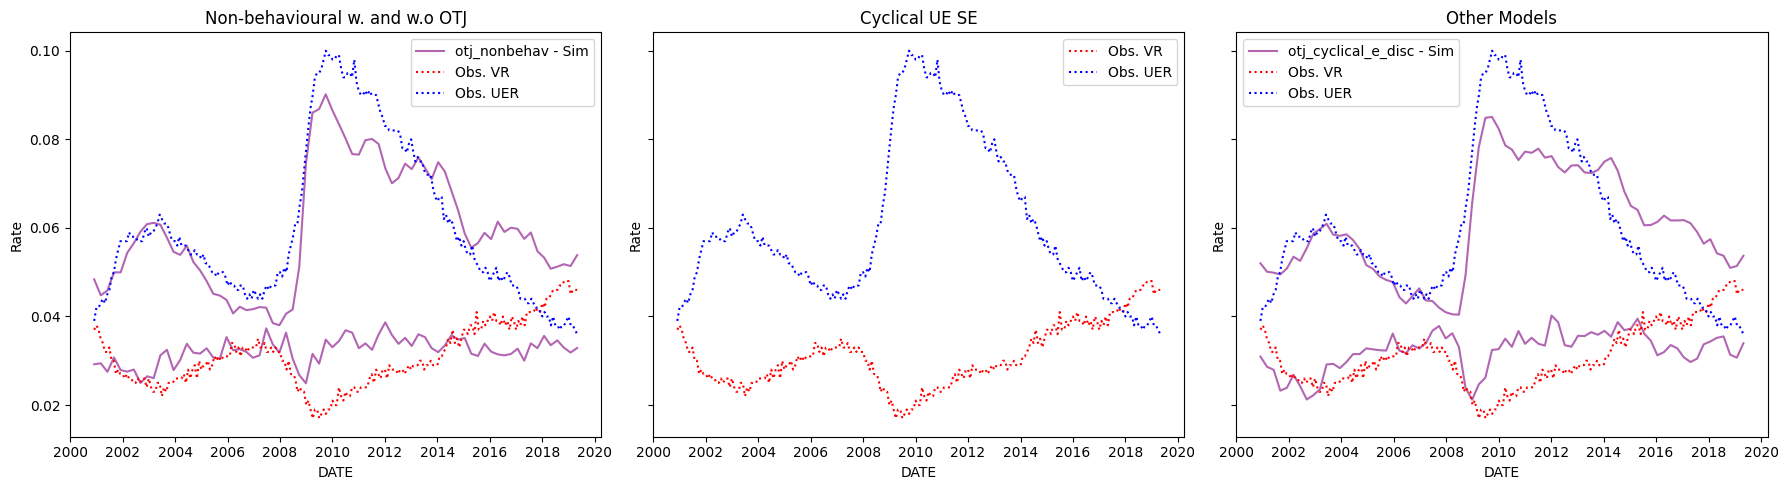

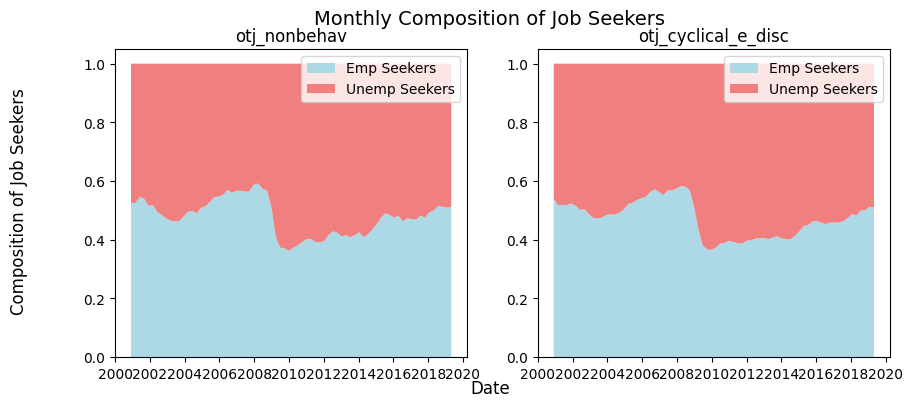

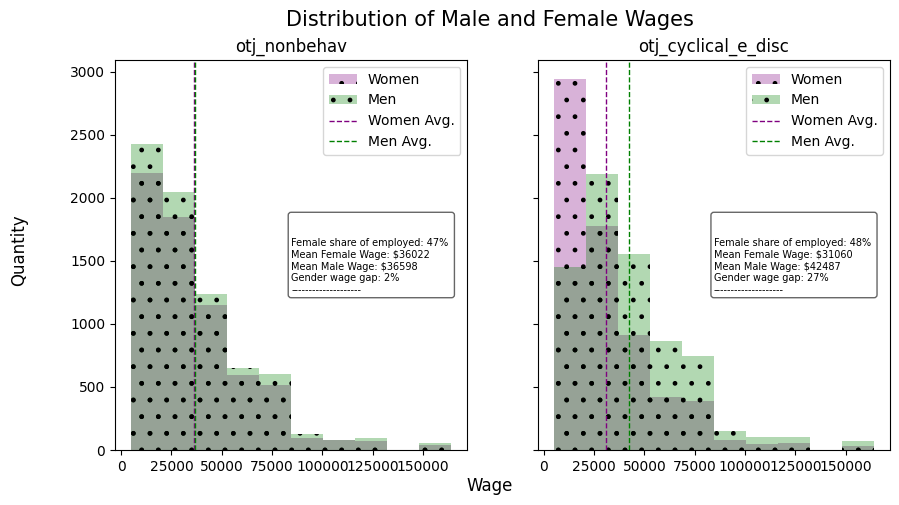

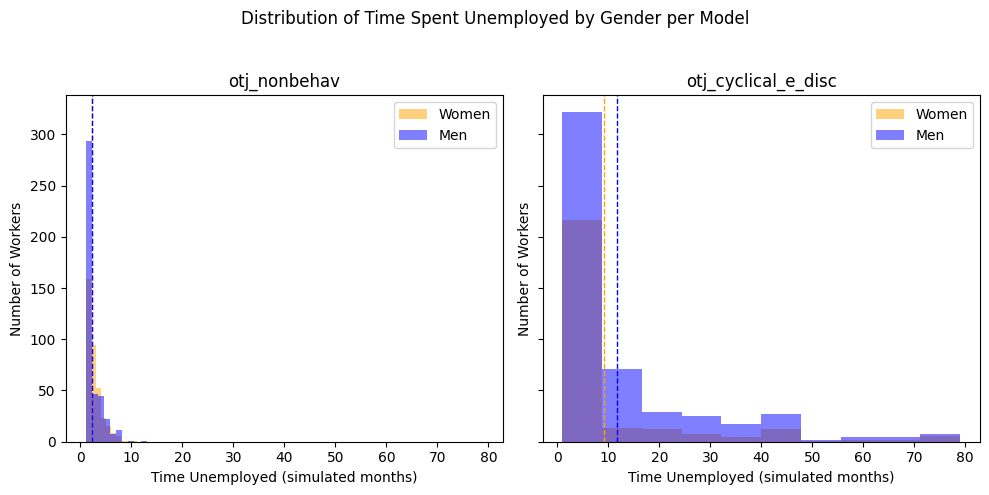

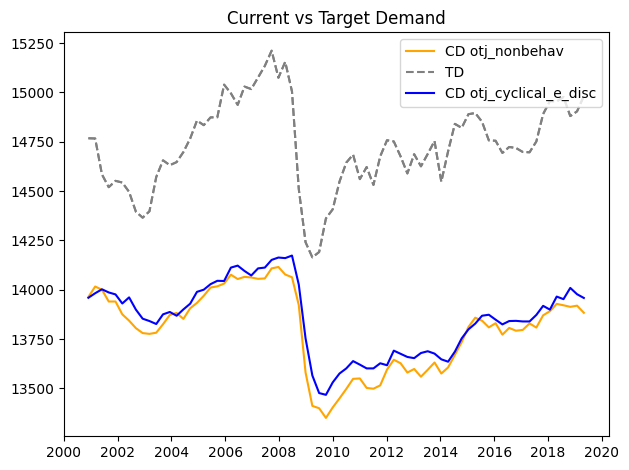

In [18]:
plot_ltuer(model_results_bc, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("ue", "Cyclical UE SE")], sep = True)
plot_bev_curve(model_results_bc, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("ue", "Cyclical UE SE")], sep = True)
plot_uer_vac(model_results_bc, observation, sep_strings = [("nonbehav", "Non-behavioural w. and w.o OTJ"), ("ue", "Cyclical UE SE")], sep = True)
plot_seeker_comp(model_results_bc, share = True)
plot_gender_gaps(net_results_bc)
plot_ltuer_dist(net_results_bc, gender = True)
plot_cd_vs_td(model_results_bc)


In [19]:
from PIL import Image, ImageDraw, ImageFont

def combine_model_images(image_dir, calib_list, sep_strings, output_path="combined_calibration.png"):
    # Load images into groups
    grouped = {match: [] for match, _ in sep_strings}
    titles = {match: title for match, title in sep_strings}
    unmatched = []

    for model_name in calib_list.keys():
        filename = f"calibration_{model_name}_sim_results.png"
        filepath = os.path.join(image_dir, filename)
        if not os.path.exists(filepath):
            continue

        img = Image.open(filepath)
        matched = False
        for match, _ in sep_strings:
            if match in model_name:
                grouped[match].append((model_name, img))
                matched = True
                break
        if not matched:
            unmatched.append((model_name, img))

    if unmatched:
        grouped["__unmatched__"] = unmatched
        titles["__unmatched__"] = "Other Models"

    # === Font and Layout Configuration ===
    title_font_size = 80
    name_font_size = 60

    title_height = title_font_size + 20
    name_height = name_font_size + 10
    spacing = 20

    try:
        font = ImageFont.truetype("arial.ttf", name_font_size)
        title_font = ImageFont.truetype("arial.ttf", title_font_size)
    except:
        font = ImageFont.load_default()
        title_font = font

    # Safely get size of the first available image
    first_img = None
    for models in grouped.values():
        if models:
            first_img = models[0][1]
            break

    if first_img is None:
        raise ValueError("No images found in any group.")

    img_width, img_height = first_img.size

    # === Canvas Size Calculation ===
    num_cols = len(grouped)
    max_rows = max(len(models) for models in grouped.values())

    total_width = num_cols * (img_width + spacing)
    total_height = max_rows * (img_height + name_height + spacing) + title_height

    combined_img = Image.new("RGB", (total_width, total_height), color="white")
    draw = ImageDraw.Draw(combined_img)

    # === Drawing images and text ===
    for col, (match, models) in enumerate(grouped.items()):
        x_offset = col * (img_width + spacing)

        # Column title
        title_text = titles[match]
        text_width = draw.textlength(title_text, font=title_font)
        draw.text((x_offset + (img_width - text_width) // 2, 5), title_text, fill="black", font=title_font)

        for row, (name, img) in enumerate(models):
            y_offset = title_height + row * (img_height + name_height + spacing)

            # Model name
            name_text_width = draw.textlength(name, font=font)
            draw.text((x_offset + (img_width - name_text_width) // 2, y_offset), name, fill="black", font=font)

            # Paste image
            combined_img.paste(img, (x_offset, y_offset + name_height))

    # === Save the result ===
    combined_img.save(output_path)
    print(f"Combined image saved to {output_path}")

combine_model_images(
    image_dir="output_23_04/",
    calib_list=calib_list,
    sep_strings=[
        ("nonbehav", "Non-behavioural w. and w.o OTJ"),
        ("ue", "Cyclical UE SE")
    ],
    output_path="all_calibrations_combined.png"
)

ValueError: No images found in any group.